### In this file, I am going to implement the multivariate predcition for the datasets below to publish the results:

- on all the features
- on 4band with the most relevant correlations

#### Preprocessing the data, and defining the necessary functions

In [1]:
### Import libraries
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint # to save the model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error as mse


In [2]:
# Read the data
df = pd.read_csv('C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Data/OneDrive_2022-10-27/Converted_to_Excel_180815 - WS2 nanobubbles on gold/01WS2_~1.csv')
# df = pd.read_csv('C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Data/OneDrive_2022-10-27/Converted_to_Excel_180815 - WS2 nanobubbles on gold/01WS2_~1 - 4.csv')
# df.dtypes # check the data type

# clean and neat the dataframe
df.iloc[1,0]='Time' # change the '#' to 'Time'
df.columns=df. iloc[1] # place the wavelenght numbers as column headers 
df = df.drop(labels=[0,1], axis=0) # remove the first two rows
df.reset_index(drop=True) # to reset the indecxes so they start from 0 again

# add time to the index
df.index = df['Time']
# drop the "Time" column
df = df.drop('Time' , axis=1)
# df=df.iloc[:,:15]
# convert the negative numbers to 0 (I think negative numbers are just noise?)
df[df < 0] = 0
df=df.reset_index(drop=True) # to reset the indecxes so they start from 0 again
df

1    591.12  591.26  591.39  591.53  591.66  591.80  591.93  592.06  592.20  \
0       1.0     5.0     9.0     8.0    16.0     6.0    15.0    12.0    19.0   
1       2.0     8.0     8.0     8.0    14.0    15.0    16.0    11.0    18.0   
2       2.0     9.0    14.0    12.0    14.0    14.0    14.0    17.0    18.0   
3       6.0     9.0     7.0    18.0    12.0    12.0    17.0    15.0    14.0   
4       0.0     7.0     7.0    12.0     7.0    13.0     9.0    18.0    14.0   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
295     1.0     9.0     9.0    11.0    10.0     9.0    10.0    15.0    16.0   
296     5.0    10.0     5.0    13.0     8.0    13.0     9.0    14.0    21.0   
297     3.0     9.0    10.0     9.0    10.0    10.0    10.0    12.0    10.0   
298     3.0     6.0     4.0     9.0     9.0    10.0    12.0    15.0    13.0   
299     7.0     3.0    10.0    11.0    17.0    13.0    13.0    13.0    18.0   

1    592.33  ...  726.97  727.10  727.23  727.37  727.50  727.63  727.76  \
0      12.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
1      16.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2      21.0  ...     0.0     0.0     0.0     0.0     2.0     0.0     0.0   
3      14.0  ...     0.0     0.0     2.0     0.0     0.0     0.0     1.0   
4      19.0  ...     0.0     0.0     0.0     2.0     0.0     0.0     0.0   
..      ...  ...     ...     ...     ...     ...     ...     ...     ...   
295    17.0  ...     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
296    19.0  ...     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
297    15.0  ...     2.0     0.0     0.0     0.0     0.0     0.0     0.0   
298    15.0  ...     0.0     2.0     0.0     5.0     0.0     0.0     0.0   
299    11.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

1    727.89  728.02  728.15  
0       0.0     0.0     0.0  
1       0.0     1.0     0.0  
2       1.0     3.0     0.0  
3       2.0     0.0     0.0  
4       0.0     0.0     0.0  
..      ...     ...     ...  
295     0.0     0.0     0.0  
296     1.0     0.0     0.0  
297     0.0     0.0     0.0  
298     0.0     0.0     0.0  
299     2.0     0.0     3.0  

[300 rows x 1024 columns]

<ipython-input-273-552cb3e69521>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time, wave, phot.T)


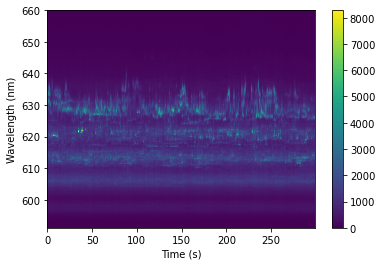

In [273]:
# plot the data as an image
df_as_np=df.to_numpy(dtype=np.single)

wave=np.array(df.columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

plt.pcolor(time, wave, phot.T)
plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
plt.ylim(ymax = 660)
# plt.yticks(ticks=df_as_np[:,100], label=test)
# save the plot
path='C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Code/QE_Forecast/Figs/'
plt.savefig(path + 'raw_image.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))
# plt.close(fig)

In [4]:
### define a function to build the model

def pred_model(X_train_norm,Y_train_norm, learning_rate=0.0001, batch_size=1):

    # batch_size=math.gcd(X_train_norm.shape[0], X_val_norm.shape[0])

    model=Sequential()
    model.add(LSTM(128,batch_input_shape=(batch_size,X_train_norm.shape[1],X_train_norm.shape[2]), return_sequences=False, stateful=True))
    model.add(Dense(20, 'relu'))
    model.add(Dense(Y_train_norm.shape[1]))
    model.summary()

    # train the model
    # cp2=ModelCheckpoint('model/group/overlapnum2' , save_best_only=True) # it saves the best model based on val error
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    return model

In [5]:
# # define a function to plot the predictions 

# from sklearn.metrics import mean_squared_error as mse
# def plot_predictions(model, X, Y, X_train, start=0, end=20):
    
#     def postprocess(pred, X_train):
#         X_mean = np.mean(X_train)
#         X_std = np.std(X_train)
#         actual = (pred * X_std) + X_mean
#         return actual

#     predictions = model_single.predict(X[start:end], batch_size=batch_size)
#     predictions_actual=postprocess(predictions, X_train)
#     Y_actual=postprocess(Y[start:end], X_train) 

#     #     plt.figure(figsize = (10,8)) # with this, you can change the size of each image


#     plt.plot(predictions_actual, c='r', label='Predictions')
#     plt.plot(Y_actual, label= 'Actual values')   
#     plt.xlabel("Time (steps of 2 seconds)")
#     plt.ylabel("Number of Photons")
#     #find the max(min) between the max(min) of predcitions and y actual as the boundary limits for plot
#     plt.ylim(ymax = max(np.amax(predictions_actual), np.amax(Y_actual))+10, ymin =min(np.amin(predictions_actual),np.amin(Y_actual))-10)
#     plt.legend() # so the label shows up

#     return mse(Y_actual, predictions_actual, squared=False) # when squared is set to false, it reteurn rmse instead of mse

# # plot
# # plot_predictions_group(model_band1, X_test_band1_norm, y_test_band1_norm, start=0, end=20)

In [6]:
# define a function to calculate the rmse 

def pred_rmse (model, X_test_norm, Y_test, X_train): # X_test is norm, whereas Y_test and X_train are NOT norm
    predictions = model.predict(X_test_norm, batch_size=batch_size)
    predictions_actual=postprocess(predictions, X_train)
  
    return mse(Y_test, predictions_actual, squared=False) # when squared is set to false, it reteurn rmse instead of mse

In [7]:
def preprocess(X, X_train):   
    X_mean = np.mean(X_train)
    X_std = np.std(X_train)
    
    X_norm = (X - X_mean)/ X_std
    return X_norm

# Now convert the data back to before normalization
def postprocess(pred, X_train):
    
    X_mean = np.mean(X_train)
    X_std = np.std(X_train)
    
    actual = (pred * X_std) + X_mean
    return actual

In [8]:
# ### plot the predictions and actual values as images, and return rmse

# def image_single(model_single,X_test_single_norm, batch_size, X_train_single, Y_test_single, phot_test_single, time_test_single, wave_test_single, thresh):
#     batch_size=1
#     predictions_single = model_single.predict(X_test_single_norm, batch_size=batch_size)
#     predictions_actual_single=postprocess(predictions_single, X_train_single)
#     rmse_single=pred_rmse(model_single, X_test_single_norm, Y_test_single, X_train_single)
#     print(rmse_single)

#     # reshape the Y so we can plot it in terms of a numpy array with wave and time
#     # we can aslo reshape the Y_test_single itself to the size of time_test_single.shape[0] and wave_test_single.shape[0]! (instead of creating phot)
#     Y_test_single_image=Y_test_single.reshape((phot_test_single.shape[0],phot_test_single.shape[1]), order='F')
#     predictions_actual_image=predictions_actual_single.reshape((phot_test_single.shape[0],phot_test_single.shape[1]), order='F')

#     plt.pcolor(time_test_single, wave_test_single, Y_test_single_image.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
#     plt.clim(0, thresh) # plot the color bar only up to values of 3000 (max value is max(phot))
# #     plt.clim(0,3000)
#     plt.colorbar()
#     plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
#     plt.title("Actual values")
#     # plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

#     plt.pcolor(time_test_single, wave_test_single, predictions_actual_image.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
#     plt.clim(0, thresh) # plot the color bar only up to values of 3000 (max value is max(phot))
# #     plt.clim(0,3000)
#     plt.colorbar()
#     plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
#     plt.title("Predicted values")
#     # plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

#### Multivariate Predcition over all the data 

In [9]:
# Define a function to convert the data to inputs and labels pairs (X and Y), considering all the features as a variate

def df_to_X_Y_multi(df, window_size): # input is numpy array. window size is time steps of inputs 
    df_as_np=df.to_numpy()
    X=[] # make an empty list
    y=[]
    
    for i in range(df_as_np.shape[0] -window_size): #defining a window over time
        row=[a for a in df_as_np[i:i+window_size,:]] # pick only the first feature
        X.append(row)
        label=df_as_np[i+window_size, :]
        y.append(label)
       
    return np.array(X), np.array(y) 

X_multi , Y_multi= df_to_X_Y_multi(df, window_size=5) 

X_train_multi, Y_train_multi = X_multi[:int(.8 * X_multi.shape[0])], Y_multi[:int(.8 * X_multi.shape[0])]
X_val_multi , Y_val_multi = X_multi[int(.8 * X_multi.shape[0]):int(.9 * X_multi.shape[0])] , Y_multi[int(.8 * X_multi.shape[0]):int(.9 * X_multi.shape[0])]
X_test_multi , Y_test_multi = X_multi[int(.9 * X_multi.shape[0]):] , Y_multi[int(.9 * X_multi.shape[0]):]
# X_train.shape , y_train.shape , X_val.shape , y_val.shape , X_test.shape , y_test.shape


# apply the preprocess to the inputs and outputs
X_train_multi_norm=preprocess(X_train_multi, X_train_multi)
X_val_multi_norm=preprocess(X_val_multi, X_train_multi)
X_test_multi_norm=preprocess(X_test_multi, X_train_multi)

Y_train_multi_norm=preprocess(Y_train_multi,X_train_multi)
Y_val_multi_norm=preprocess(Y_val_multi,X_train_multi)
Y_test_multi_norm=preprocess(Y_test_multi,X_train_multi)

X_train_multi_norm.shape , Y_train_multi_norm.shape , X_val_multi_norm.shape , Y_val_multi_norm.shape , X_test_multi_norm.shape , Y_test_multi_norm.shape


((236, 5, 1024),
 (236, 1024),
 (29, 5, 1024),
 (29, 1024),
 (30, 5, 1024),
 (30, 1024))

In [10]:
cp_multi=ModelCheckpoint('model/publish2/multivariate/' , save_best_only=True) # it saves the best model based on val error
model_multi=pred_model( X_train_norm=X_train_multi_norm, Y_train_norm=Y_train_multi_norm, batch_size=1)
model_multi.fit(X_train_multi_norm, Y_train_multi_norm, validation_data=(X_val_multi_norm, Y_val_multi_norm), batch_size=1, epochs=220, callbacks=[cp_multi])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 128)                  590336    
                                                                 
 dense (Dense)               (1, 20)                   2580      
                                                                 
 dense_1 (Dense)             (1, 1024)                 21504     
                                                                 
Total params: 614,420
Trainable params: 614,420
Non-trainable params: 0
_________________________________________________________________
Epoch 1/220
234/236 [============================>.] - ETA: 0s - loss: 0.6045 - root_mean_squared_error: 0.7775

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 14s 50ms/step - loss: 0.6009 - root_mean_squared_error: 0.7752 - val_loss: 0.2257 - val_root_mean_squared_error: 0.4751
Epoch 2/220
232/236 [============================>.] - ETA: 0s - loss: 0.1514 - root_mean_squared_error: 0.3891

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 12s 50ms/step - loss: 0.1501 - root_mean_squared_error: 0.3874 - val_loss: 0.1485 - val_root_mean_squared_error: 0.3854
Epoch 3/220
236/236 [==============================] - ETA: 0s - loss: 0.1266 - root_mean_squared_error: 0.3558

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 11s 48ms/step - loss: 0.1266 - root_mean_squared_error: 0.3558 - val_loss: 0.1465 - val_root_mean_squared_error: 0.3827
Epoch 4/220
232/236 [============================>.] - ETA: 0s - loss: 0.1253 - root_mean_squared_error: 0.3539

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 11s 47ms/step - loss: 0.1247 - root_mean_squared_error: 0.3531 - val_loss: 0.1415 - val_root_mean_squared_error: 0.3762
Epoch 5/220
235/236 [============================>.] - ETA: 0s - loss: 0.1229 - root_mean_squared_error: 0.3505

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 44ms/step - loss: 0.1231 - root_mean_squared_error: 0.3509 - val_loss: 0.1393 - val_root_mean_squared_error: 0.3733
Epoch 6/220
236/236 [==============================] - 2s 9ms/step - loss: 0.1224 - root_mean_squared_error: 0.3499 - val_loss: 0.1405 - val_root_mean_squared_error: 0.3749
Epoch 7/220
232/236 [============================>.] - ETA: 0s - loss: 0.1223 - root_mean_squared_error: 0.3497

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 11s 47ms/step - loss: 0.1216 - root_mean_squared_error: 0.3487 - val_loss: 0.1390 - val_root_mean_squared_error: 0.3729
Epoch 8/220
236/236 [==============================] - 2s 8ms/step - loss: 0.1211 - root_mean_squared_error: 0.3479 - val_loss: 0.1398 - val_root_mean_squared_error: 0.3739
Epoch 9/220
232/236 [============================>.] - ETA: 0s - loss: 0.1210 - root_mean_squared_error: 0.3479

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 11s 45ms/step - loss: 0.1210 - root_mean_squared_error: 0.3479 - val_loss: 0.1389 - val_root_mean_squared_error: 0.3727
Epoch 10/220
236/236 [==============================] - 2s 9ms/step - loss: 0.1206 - root_mean_squared_error: 0.3472 - val_loss: 0.1390 - val_root_mean_squared_error: 0.3728
Epoch 11/220
231/236 [============================>.] - ETA: 0s - loss: 0.1218 - root_mean_squared_error: 0.3490

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 13s 54ms/step - loss: 0.1205 - root_mean_squared_error: 0.3471 - val_loss: 0.1388 - val_root_mean_squared_error: 0.3725
Epoch 12/220
234/236 [============================>.] - ETA: 0s - loss: 0.1206 - root_mean_squared_error: 0.3472

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 11s 45ms/step - loss: 0.1201 - root_mean_squared_error: 0.3466 - val_loss: 0.1383 - val_root_mean_squared_error: 0.3719
Epoch 13/220
236/236 [==============================] - ETA: 0s - loss: 0.1195 - root_mean_squared_error: 0.3457

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 11s 45ms/step - loss: 0.1195 - root_mean_squared_error: 0.3457 - val_loss: 0.1371 - val_root_mean_squared_error: 0.3702
Epoch 14/220
233/236 [============================>.] - ETA: 0s - loss: 0.1194 - root_mean_squared_error: 0.3456

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 11s 46ms/step - loss: 0.1189 - root_mean_squared_error: 0.3449 - val_loss: 0.1344 - val_root_mean_squared_error: 0.3666
Epoch 15/220
236/236 [==============================] - 2s 8ms/step - loss: 0.1176 - root_mean_squared_error: 0.3429 - val_loss: 0.1353 - val_root_mean_squared_error: 0.3678
Epoch 16/220
234/236 [============================>.] - ETA: 0s - loss: 0.1159 - root_mean_squared_error: 0.3404

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 43ms/step - loss: 0.1158 - root_mean_squared_error: 0.3403 - val_loss: 0.1336 - val_root_mean_squared_error: 0.3655
Epoch 17/220
231/236 [============================>.] - ETA: 0s - loss: 0.1136 - root_mean_squared_error: 0.3370

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 39ms/step - loss: 0.1142 - root_mean_squared_error: 0.3380 - val_loss: 0.1290 - val_root_mean_squared_error: 0.3592
Epoch 18/220
236/236 [==============================] - 2s 8ms/step - loss: 0.1129 - root_mean_squared_error: 0.3360 - val_loss: 0.1292 - val_root_mean_squared_error: 0.3594
Epoch 19/220
236/236 [==============================] - 2s 8ms/step - loss: 0.1114 - root_mean_squared_error: 0.3338 - val_loss: 0.1304 - val_root_mean_squared_error: 0.3610
Epoch 20/220
236/236 [==============================] - ETA: 0s - loss: 0.1099 - root_mean_squared_error: 0.3315

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 40ms/step - loss: 0.1099 - root_mean_squared_error: 0.3315 - val_loss: 0.1266 - val_root_mean_squared_error: 0.3558
Epoch 21/220
231/236 [============================>.] - ETA: 0s - loss: 0.1087 - root_mean_squared_error: 0.3297

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 40ms/step - loss: 0.1087 - root_mean_squared_error: 0.3297 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3517
Epoch 22/220
231/236 [============================>.] - ETA: 0s - loss: 0.1083 - root_mean_squared_error: 0.3291

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 40ms/step - loss: 0.1075 - root_mean_squared_error: 0.3279 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 23/220
236/236 [==============================] - 2s 8ms/step - loss: 0.1061 - root_mean_squared_error: 0.3258 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3504
Epoch 24/220
230/236 [============================>.] - ETA: 0s - loss: 0.1064 - root_mean_squared_error: 0.3261

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 40ms/step - loss: 0.1056 - root_mean_squared_error: 0.3250 - val_loss: 0.1208 - val_root_mean_squared_error: 0.3475
Epoch 25/220
236/236 [==============================] - 2s 7ms/step - loss: 0.1049 - root_mean_squared_error: 0.3239 - val_loss: 0.1217 - val_root_mean_squared_error: 0.3488
Epoch 26/220
232/236 [============================>.] - ETA: 0s - loss: 0.1034 - root_mean_squared_error: 0.3215

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 41ms/step - loss: 0.1037 - root_mean_squared_error: 0.3221 - val_loss: 0.1196 - val_root_mean_squared_error: 0.3458
Epoch 27/220
236/236 [==============================] - ETA: 0s - loss: 0.1034 - root_mean_squared_error: 0.3215

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 39ms/step - loss: 0.1034 - root_mean_squared_error: 0.3215 - val_loss: 0.1187 - val_root_mean_squared_error: 0.3445
Epoch 28/220
236/236 [==============================] - 2s 7ms/step - loss: 0.1030 - root_mean_squared_error: 0.3209 - val_loss: 0.1208 - val_root_mean_squared_error: 0.3475
Epoch 29/220
236/236 [==============================] - ETA: 0s - loss: 0.1018 - root_mean_squared_error: 0.3191

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 40ms/step - loss: 0.1018 - root_mean_squared_error: 0.3191 - val_loss: 0.1169 - val_root_mean_squared_error: 0.3419
Epoch 30/220
236/236 [==============================] - 2s 8ms/step - loss: 0.1014 - root_mean_squared_error: 0.3184 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 31/220
236/236 [==============================] - 2s 8ms/step - loss: 0.1008 - root_mean_squared_error: 0.3175 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3457
Epoch 32/220
236/236 [==============================] - 2s 8ms/step - loss: 0.1000 - root_mean_squared_error: 0.3162 - val_loss: 0.1202 - val_root_mean_squared_error: 0.3467
Epoch 33/220
236/236 [==============================] - 2s 9ms/step - loss: 0.0986 - root_mean_squared_error: 0.3141 - val_loss: 0.1180 - val_root_mean_squared_error: 0.3436
Epoch 34/220
233/236 [============================>.] - ETA: 0s - loss: 0.0994 - root_mean_squared_error: 0.3153

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 39ms/step - loss: 0.0997 - root_mean_squared_error: 0.3158 - val_loss: 0.1159 - val_root_mean_squared_error: 0.3405
Epoch 35/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0989 - root_mean_squared_error: 0.3144 - val_loss: 0.1164 - val_root_mean_squared_error: 0.3411
Epoch 36/220
236/236 [==============================] - ETA: 0s - loss: 0.0980 - root_mean_squared_error: 0.3130

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 40ms/step - loss: 0.0980 - root_mean_squared_error: 0.3130 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3397
Epoch 37/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0974 - root_mean_squared_error: 0.3121 - val_loss: 0.1167 - val_root_mean_squared_error: 0.3416
Epoch 38/220
236/236 [==============================] - ETA: 0s - loss: 0.0969 - root_mean_squared_error: 0.3113

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 41ms/step - loss: 0.0969 - root_mean_squared_error: 0.3113 - val_loss: 0.1144 - val_root_mean_squared_error: 0.3382
Epoch 39/220
231/236 [============================>.] - ETA: 0s - loss: 0.0952 - root_mean_squared_error: 0.3086

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 40ms/step - loss: 0.0968 - root_mean_squared_error: 0.3111 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3371
Epoch 40/220
236/236 [==============================] - 2s 10ms/step - loss: 0.0959 - root_mean_squared_error: 0.3097 - val_loss: 0.1164 - val_root_mean_squared_error: 0.3412
Epoch 41/220
235/236 [============================>.] - ETA: 0s - loss: 0.0955 - root_mean_squared_error: 0.3090

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 41ms/step - loss: 0.0953 - root_mean_squared_error: 0.3087 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3371
Epoch 42/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0952 - root_mean_squared_error: 0.3086 - val_loss: 0.1140 - val_root_mean_squared_error: 0.3376
Epoch 43/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0954 - root_mean_squared_error: 0.3089 - val_loss: 0.1155 - val_root_mean_squared_error: 0.3398
Epoch 44/220
236/236 [==============================] - 2s 9ms/step - loss: 0.0944 - root_mean_squared_error: 0.3072 - val_loss: 0.1137 - val_root_mean_squared_error: 0.3372
Epoch 45/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0938 - root_mean_squared_error: 0.3062 - val_loss: 0.1186 - val_root_mean_squared_error: 0.3443
Epoch 46/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0932 - root_mean_squared_error: 0.3053 - val_loss: 0.1158 - val

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 41ms/step - loss: 0.0929 - root_mean_squared_error: 0.3047 - val_loss: 0.1131 - val_root_mean_squared_error: 0.3363
Epoch 49/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0926 - root_mean_squared_error: 0.3043 - val_loss: 0.1163 - val_root_mean_squared_error: 0.3411
Epoch 50/220
236/236 [==============================] - ETA: 0s - loss: 0.0925 - root_mean_squared_error: 0.3041

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 39ms/step - loss: 0.0925 - root_mean_squared_error: 0.3041 - val_loss: 0.1124 - val_root_mean_squared_error: 0.3353
Epoch 51/220
230/236 [============================>.] - ETA: 0s - loss: 0.0902 - root_mean_squared_error: 0.3004

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 41ms/step - loss: 0.0918 - root_mean_squared_error: 0.3029 - val_loss: 0.1124 - val_root_mean_squared_error: 0.3353
Epoch 52/220
230/236 [============================>.] - ETA: 0s - loss: 0.0921 - root_mean_squared_error: 0.3035

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 40ms/step - loss: 0.0914 - root_mean_squared_error: 0.3024 - val_loss: 0.1121 - val_root_mean_squared_error: 0.3349
Epoch 53/220
232/236 [============================>.] - ETA: 0s - loss: 0.0923 - root_mean_squared_error: 0.3038

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 40ms/step - loss: 0.0918 - root_mean_squared_error: 0.3030 - val_loss: 0.1112 - val_root_mean_squared_error: 0.3335
Epoch 54/220
234/236 [============================>.] - ETA: 0s - loss: 0.0914 - root_mean_squared_error: 0.3024

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 9s 40ms/step - loss: 0.0911 - root_mean_squared_error: 0.3019 - val_loss: 0.1110 - val_root_mean_squared_error: 0.3332
Epoch 55/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0912 - root_mean_squared_error: 0.3020 - val_loss: 0.1143 - val_root_mean_squared_error: 0.3381
Epoch 56/220
236/236 [==============================] - 2s 9ms/step - loss: 0.0906 - root_mean_squared_error: 0.3009 - val_loss: 0.1120 - val_root_mean_squared_error: 0.3346
Epoch 57/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0903 - root_mean_squared_error: 0.3005 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3374
Epoch 58/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0901 - root_mean_squared_error: 0.3001 - val_loss: 0.1148 - val_root_mean_squared_error: 0.3388
Epoch 59/220
236/236 [==============================] - 2s 9ms/step - loss: 0.0897 - root_mean_squared_error: 0.2995 - val_loss: 0.1159 - val_

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 10s 44ms/step - loss: 0.0889 - root_mean_squared_error: 0.2982 - val_loss: 0.1108 - val_root_mean_squared_error: 0.3328
Epoch 63/220
236/236 [==============================] - 2s 9ms/step - loss: 0.0889 - root_mean_squared_error: 0.2981 - val_loss: 0.1135 - val_root_mean_squared_error: 0.3369
Epoch 64/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0890 - root_mean_squared_error: 0.2984 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3397
Epoch 65/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0885 - root_mean_squared_error: 0.2975 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3370
Epoch 66/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0884 - root_mean_squared_error: 0.2974 - val_loss: 0.1144 - val_root_mean_squared_error: 0.3382
Epoch 67/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0885 - root_mean_squared_error: 0.2975 - val_loss: 0.1124 - val

236/236 [==============================] - 2s 9ms/step - loss: 0.0784 - root_mean_squared_error: 0.2800 - val_loss: 0.1206 - val_root_mean_squared_error: 0.3472
Epoch 110/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0781 - root_mean_squared_error: 0.2795 - val_loss: 0.1201 - val_root_mean_squared_error: 0.3465
Epoch 111/220
236/236 [==============================] - 2s 10ms/step - loss: 0.0776 - root_mean_squared_error: 0.2786 - val_loss: 0.1142 - val_root_mean_squared_error: 0.3379
Epoch 112/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0771 - root_mean_squared_error: 0.2776 - val_loss: 0.1138 - val_root_mean_squared_error: 0.3374
Epoch 113/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0774 - root_mean_squared_error: 0.2782 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3375
Epoch 114/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0769 - root_mean_squared_error: 0.2772 - val_loss: 0.1228 -

Epoch 156/220
236/236 [==============================] - 2s 10ms/step - loss: 0.0665 - root_mean_squared_error: 0.2579 - val_loss: 0.1120 - val_root_mean_squared_error: 0.3347
Epoch 157/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0663 - root_mean_squared_error: 0.2575 - val_loss: 0.1166 - val_root_mean_squared_error: 0.3414
Epoch 158/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0660 - root_mean_squared_error: 0.2569 - val_loss: 0.1128 - val_root_mean_squared_error: 0.3358
Epoch 159/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0663 - root_mean_squared_error: 0.2574 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3397
Epoch 160/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0663 - root_mean_squared_error: 0.2574 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3495
Epoch 161/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0655 - root_mean_squared_error: 0.2560 - val_

INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


INFO:tensorflow:Assets written to: model/publish2/multivariate\assets


236/236 [==============================] - 11s 47ms/step - loss: 0.0635 - root_mean_squared_error: 0.2521 - val_loss: 0.1106 - val_root_mean_squared_error: 0.3325
Epoch 171/220
236/236 [==============================] - 2s 9ms/step - loss: 0.0629 - root_mean_squared_error: 0.2508 - val_loss: 0.1133 - val_root_mean_squared_error: 0.3365
Epoch 172/220
236/236 [==============================] - 2s 9ms/step - loss: 0.0629 - root_mean_squared_error: 0.2507 - val_loss: 0.1199 - val_root_mean_squared_error: 0.3463
Epoch 173/220
236/236 [==============================] - 2s 10ms/step - loss: 0.0629 - root_mean_squared_error: 0.2508 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3457
Epoch 174/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0621 - root_mean_squared_error: 0.2493 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3375
Epoch 175/220
236/236 [==============================] - 2s 9ms/step - loss: 0.0619 - root_mean_squared_error: 0.2487 - val_loss: 0.1138

Epoch 217/220
236/236 [==============================] - 2s 10ms/step - loss: 0.0534 - root_mean_squared_error: 0.2310 - val_loss: 0.1171 - val_root_mean_squared_error: 0.3422
Epoch 218/220
236/236 [==============================] - 2s 11ms/step - loss: 0.0531 - root_mean_squared_error: 0.2304 - val_loss: 0.1144 - val_root_mean_squared_error: 0.3383
Epoch 219/220
236/236 [==============================] - 2s 9ms/step - loss: 0.0531 - root_mean_squared_error: 0.2304 - val_loss: 0.1202 - val_root_mean_squared_error: 0.3467
Epoch 220/220
236/236 [==============================] - 2s 8ms/step - loss: 0.0527 - root_mean_squared_error: 0.2296 - val_loss: 0.1153 - val_root_mean_squared_error: 0.3396


In [173]:
column_index = df.columns.get_loc(605.95)
column_index


110

Total rmse over test set for all wavelenghts in multivariate model is :79.11670099164628


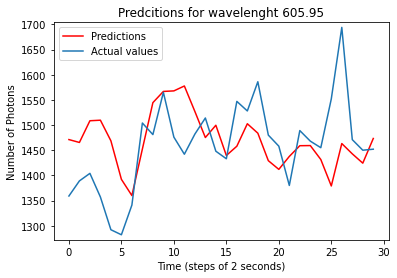

In [174]:
# load the trained model
model_multi=tf.keras.models.load_model('model/publish2/multivariate/')
batch_size=1
# predict individual wavelengths
predictions_multi = model_multi.predict(X_test_multi_norm, batch_size=1)
predictions_actual_multi=postprocess(predictions_multi, X_train_multi)

#get the column index of a specific wavelength
column_index = df.columns.get_loc(605.95)

w=column_index
plt.plot(predictions_actual_multi[:,w], c='r', label='Predictions')
plt.plot(Y_test_multi[:,w], label= 'Actual values')   
plt.xlabel("Time (steps of 2 seconds)")
plt.ylabel("Number of Photons")
plt.title("Predcitions for wavelenght " + str(df.columns[w]))
#find the max(min) between the max(min) of predcitions and y actual as the boundary limits for plot
plt.ylim(ymax = max(np.amax(predictions_actual_multi[:,w]), np.amax(Y_test_multi[:,w]))+10, ymin =min(np.amin(predictions_actual_multi[:,w]),np.amin(Y_test_multi[:,w]))-10)
plt.legend() # so the label shows up

# return total rmse
rmse_multi=pred_rmse (model=model_multi, X_test_norm=X_test_multi_norm, Y_test=Y_test_multi, X_train=X_train_multi)
print("Total rmse over test set for all wavelenghts in multivariate model is :" + str(rmse_multi))

<ipython-input-190-8931ad7f76fc>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_multi, wave_test_multi, Y_test_multi.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
<ipython-input-190-8931ad7f76fc>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_multi, wave_test_multi, predictions_actual_multi.T) # we can write phot_test_single instead of Y_test_single.image as well

Total rmse over test set using prediction model is :79.11670099164628
Total rmse over test set using shifted model is :79.40177462409554


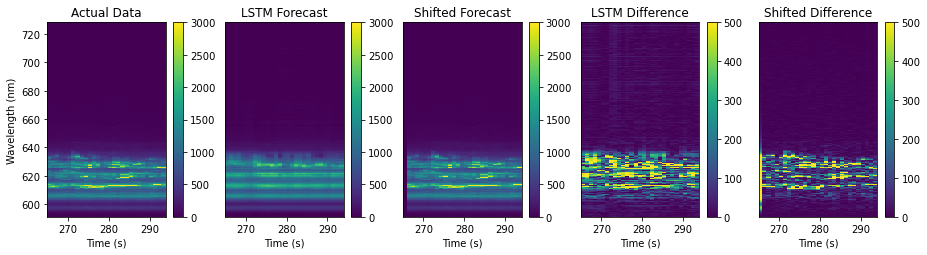

In [190]:
### plot the predictions and actual values as images 
## (since here is the problem of multivariate and we have each column and time, we don't need to modify wave and time much)

thresh1_multi=3000
thresh2_multi=500


window_size=5

time_test_multi=np.array(df.index[int(0.9*(df_as_np.shape[0] -window_size)):df_as_np.shape[0] -window_size])
wave_test_multi=np.array(df.columns)

# shifted actual data
shifted_Y_multi=np.zeros((Y_test_multi.shape[0], Y_test_multi.shape[1]))                                 
for i in range(shifted_Y_multi.shape[0]-1):
    shifted_Y_multi[i+1,:]=Y_test_multi[i,:]
    
        
plt.subplot(1,5,1)
plt.pcolor(time_test_multi, wave_test_multi, Y_test_multi.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
#plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.clim(0,thresh1_multi)
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
plt.title("Actual Data")
# plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

plt.subplot(1,5,2)
plt.pcolor(time_test_multi, wave_test_multi, predictions_actual_multi.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
#plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.clim(0,thresh1_multi)
plt.colorbar()
plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
plt.yticks([])   # hide the y ticks
plt.title("LSTM Forecast")
# plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

plt.subplot(1,5,3)
plt.pcolor(time_test_multi, wave_test_multi, shifted_Y_multi.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
#plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.clim(0,thresh1_multi)
plt.colorbar()
plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
plt.yticks([])   # hide the y ticks
plt.title("Shifted Forecast")
# plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

#plot the abs difference of the actual data and predcited data
plt.subplot(1,5,4)
plt.pcolor(time_test_multi, wave_test_multi, (abs(Y_test_multi-predictions_actual_multi)).T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
plt.clim(0,thresh2_multi)
plt.colorbar()
plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
plt.yticks([])   # hide the y ticks
plt.title("LSTM Difference")

#plot the abs difference of the actual data and the shifted data
plt.subplot(1,5,5)
plt.pcolor(time_test_multi, wave_test_multi, (abs(Y_test_multi-shifted_Y_multi)).T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
plt.clim(0,thresh2_multi)
plt.colorbar()
plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
plt.yticks([])   # hide the y ticks
plt.title("Shifted Difference")

plt.subplots_adjust(wspace=0.2, hspace=0.6, left=0.01, top=0.8, right=2)  
# save the images
path='C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Code/QE_Forecast/Figs/'
plt.savefig(path + 'multi_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))
# rmse1=mse(Y_test_multi, predictions_actual_multi, squared=False)
rmse2=mse(Y_test_multi, shifted_Y_multi, squared=False)

print("Total rmse over test set using prediction model is :" + str(rmse_multi))
print("Total rmse over test set using shifted model is :" + str(rmse2))    




In [ ]:
#### Calculating the rmse corresponding to the wavevelghts within each band, considering the first model

In [127]:
# band1:
y_multi_band1=Y_test_multi[:,ss_band1:ee_band1]
y_multi_band1_predict=predictions_actual_multi[:,ss_band1:ee_band1]
band1_multi_rmse=mse(y_multi_band1, y_multi_band1_predict, squared=False)

y_multi_band2=Y_test_multi[:,ss_band2:ee_band2]
y_multi_band2_predict=predictions_actual_multi[:,ss_band2:ee_band2]
band2_multi_rmse=mse(y_multi_band2, y_multi_band2_predict, squared=False)

y_multi_band3=Y_test_multi[:,ss_band3:ee_band3]
y_multi_band3_predict=predictions_actual_multi[:,ss_band3:ee_band3]
band3_multi_rmse=mse(y_multi_band3, y_multi_band3_predict, squared=False)

y_multi_band4=Y_test_multi[:,ss_band4:ee_band4]
y_multi_band4_predict=predictions_actual_multi[:,ss_band4:ee_band4]
band4_multi_rmse=mse(y_multi_band4, y_multi_band4_predict, squared=False)

print(band1_multi_rmse), print(band2_multi_rmse), print(band3_multi_rmse), print(band4_multi_rmse)

103.41969362321655
336.80690311555463
381.8806052242756
326.69857610189473


(None, None, None, None)

#### Multivarite prediction for a group of 8 wavelegths


In [60]:
# # # Define a function to convert the data to inputs and labels pairs (X and Y), considering all the features as a variate

# num=8
# j_start=216

# X_multi_group , Y_multi_group= df_to_X_Y_multi(df.iloc[:,j_start:j_start+num], window_size=5) 

# X_train_multi_group, Y_train_multi_group = X_multi_group[:int(.8 * X_multi_group.shape[0])], Y_multi_group[:int(.8 * X_multi_group.shape[0])]
# X_val_multi_group , Y_val_multi_group = X_multi_group[int(.8 * X_multi_group.shape[0]):int(.9 * X_multi_group.shape[0])] , Y_multi_group[int(.8 * X_multi_group.shape[0]):int(.9 * X_multi_group.shape[0])]
# X_test_multi_group , Y_test_multi_group = X_multi_group[int(.9 * X_multi_group.shape[0]):] , Y_multi_group[int(.9 * X_multi_group.shape[0]):]
# # X_train.shape , y_train.shape , X_val.shape , y_val.shape , X_test.shape , y_test.shape


# # apply the preprocess to the inputs and outputs
# X_train_multi_group_norm=preprocess(X_train_multi_group, X_train_multi_group)
# X_val_multi_group_norm=preprocess(X_val_multi_group, X_train_multi_group)
# X_test_multi_group_norm=preprocess(X_test_multi_group, X_train_multi_group)

# Y_train_multi_group_norm=preprocess(Y_train_multi_group,X_train_multi_group)
# Y_val_multi_group_norm=preprocess(Y_val_multi_group,X_train_multi_group)
# Y_test_multi_group_norm=preprocess(Y_test_multi_group,X_train_multi_group)

# X_train_multi_group_norm.shape , Y_train_multi_group_norm.shape , X_val_multi_group_norm.shape , Y_val_multi_group_norm.shape , X_test_multi_group_norm.shape , Y_test_multi_group_norm.shape


In [21]:
###### I figured out defining phot like the way I did above (which I  have commented now) has a problem! (proof are the two cells below)

In [61]:
# cp_multi_group=ModelCheckpoint('model/publish2/multivariate_group/' , save_best_only=True) # it saves the best model based on val error
# model_multi_group=pred_model( X_train_norm=X_train_multi_group_norm, Y_train_norm=Y_train_multi_group_norm, batch_size=1)
# model_multi_group.fit(X_train_multi_group_norm, Y_train_multi_group_norm, validation_data=(X_val_multi_group_norm, Y_val_multi_group_norm), batch_size=1, epochs=200, callbacks=[cp_multi_group])

In [62]:

# batch_size=1
# # predict individual w_groupavelengths
# predictions_multi_group = model_multi_group.predict(X_test_multi_group_norm, batch_size=1)
# predictions_actual_multi_group=postprocess(predictions_multi_group, X_train_multi_group)

# # w_group is in range[0, num - j_start]
# w_group= 4
# plt.plot(predictions_actual_multi_group[:,w_group], c='r', label='Predictions')
# plt.plot(Y_test_multi_group[:,w_group], label= 'Actual values')   
# plt.xlabel("Time (steps of 2 seconds)")
# plt.ylabel("Number of Photons")
# plt.title("Predcitions for w_groupavelenght " + str(df.columns[j_start+w_group]))
# #find the max(min) betw_groupeen the max(min) of predcitions and y actual as the boundary limits for plot
# plt.ylim(ymax = max(np.amax(predictions_actual_multi_group[:,w_group]), np.amax(Y_test_multi_group[:,w_group]))+10, ymin =min(np.amin(predictions_actual_multi_group[:,w_group]),np.amin(Y_test_multi_group[:,w_group]))-10)
# plt.legend() # so the label show_groups up

# # return total rmse
# rmse_multi_group=pred_rmse (model_multi_group, X_test_multi_group_norm, Y_test_multi_group, X_train_multi_group)
# print("Total rmse over test set for all w_groupavelenghts in multi_groupvariate model is :" + str(rmse_multi_group))

In [63]:
# ### plot the predictions and actual values as images 
# ## (since here is the problem of multi_groupvariate and we have each column and time, we don't need to modify wave and time much)

# window_size=5

# time_test_multi_group=np.array(df.index[int(0.9*(df_as_np.shape[0] -window_size)):df_as_np.shape[0] -window_size])
# wave_test_multi_group=np.array(df.columns[j_start:j_start+num])

# plt.subplot(1,2,1) # plot the figs side by side
# plt.pcolor(time_test_multi_group, wave_test_multi_group, Y_test_multi_group.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
# plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
# plt.colorbar()
# plt.xlabel("Time (s)")
# plt.ylabel("Wavelength (nm)")
# plt.title("Actual values")
# # plt.ylim(ymax = 630, ymin = 618)
# # plt.show()

# plt.subplot(1,2,2) # plot the figs side by side
# plt.pcolor(time_test_multi_group, wave_test_multi_group, predictions_actual_multi_group.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
# plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
# plt.colorbar()
# plt.xlabel("Time (s)")
# plt.ylabel("Wavelength (nm)")
# plt.title("Predicted values")
# # plt.ylim(ymax = 630, ymin = 618)
# # plt.show()
# plt.subplots_adjust(wspace=0.3, hspace=0.6, left=0.01, top=0.8, right=1.4)  

#### Multivariate predcitions for four bands (meaning considering all wavelength in the band)

In [42]:
# Define a function to convert the data to inputs and labels pairs (X and Y), considering a band of wavelengths

def df_to_X_Y_band(df, window_size, ss=100, ee=128): 
    df_as_np=df.iloc[:,ss:ee].to_numpy()
    X=[] # make an empty list
    Y=[]
    for i in range(len(df_as_np)-window_size): # there is overlap between windows in time.
        row=[a for a in df_as_np[i:i+window_size]] # we write the for loop to make every variable in a []. Here we consider all the features as input
        X.append(row)

        label=df_as_np[i+window_size] # predict only one feature (col)
        Y.append(label)
        
    X=np.array(X)
    Y=np.array(Y)
    
    window_size=5

    X_band , Y_band= X, Y
    # Split the data to train, val and test by 80,10 and 10% of the data
    X_train_band, Y_train_band = X_band[:int(.8 * X_band.shape[0])-1], Y_band[:int(.8 * X_band.shape[0]-1)]
    X_val_band , Y_val_band = X_band[int(.8 * X_band.shape[0]-2):int(.9 * X_band.shape[0])] , Y_band[int(.8 * X_band.shape[0])-2:int(.9 * X_band.shape[0])]
    X_test_band , Y_test_band = X_band[int(.9 * X_band.shape[0]):] , Y_band[int(.9 * X_band.shape[0]):]
#     X_train_band.shape , Y_train_band.shape , X_val_band.shape , Y_val_band.shape , X_test_band.shape , Y_test_band.shape

    # apply the preprocess to the inputs and outputs
    X_train_band_norm=preprocess(X_train_band, X_train_band)
    X_val_band_norm=preprocess(X_val_band, X_train_band)
    X_test_band_norm=preprocess(X_test_band, X_train_band)

    Y_train_band_norm=preprocess(Y_train_band,X_train_band)
    Y_val_band_norm=preprocess(Y_val_band,X_train_band)
    Y_test_band_norm=preprocess(Y_test_band,X_train_band)

    return X_train_band_norm , Y_train_band_norm , X_val_band_norm , Y_val_band_norm , X_test_band_norm , Y_test_band_norm, Y_test_band, X_train_band


In [320]:
# Plot function and calculate rmse

from sklearn.metrics import mean_squared_error as mse
def plot_predictions_band(model_band, X_test_band_norm, X_train_band, Y_test_band, start=0, end=20, ss=100, ee=128, wave_to_save=2):
#     predictions=  model.predict(X_norm[start:end], batch_size=batch_size)
#     predictions_actual=postprocess(predictions,  X_train_band1)
#     Y_actual=postprocess(Y[start:end],  X_norm_train_band1) 
    predictions_band = model_band.predict(X_test_band_norm, batch_size=batch_size)
    predictions_actual_band=postprocess(predictions_band, X_train_band)
    
    plt.figure(figsize = (10,8)) # with this, you can change the size of each image
    path='C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Code/QE_Forecast/Figs/'
    
    num_wave=predictions_actual_band.shape[1]
    
    for i in range(num_wave):
    
        plt.subplot(50, 2, i+1) # #the figure has 10 row, 3 columns, and this plot is the first plot.
        plt.plot(predictions_actual_band[:,i], c='r', label='Predictions for ' + str(df.iloc[:,ss:ee].columns[i]) + ' wavelength')
        plt.plot(Y_test_band[:,i], label= 'Actual values')   
        plt.xlabel("Time (steps of 2 seconds)")
        plt.ylabel("Number of Photons")
        #find the maX_norm(min) between the maX_norm(min) of predcitions and y actual as the boundary limits for plot
        plt.ylim(ymax = max(np.amax(predictions_actual_band[:,i]), np.amax(Y_test_band[:,i]))+20, ymin =min(np.amin(predictions_actual_band[:,i]),np.amin(Y_test_band[:,i]))-20)
        plt.legend() # so the label shows up

    plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.01, top=9, right=1.4)   
    total_rmse=mse(Y_test_band, predictions_actual_band, squared=False)
    # save a specific plot for lstm prediction as well as shifted prediction
    
    # shifted actual data
    shifted=np.zeros((Y_test_band[:,wave_to_save].shape[0], 1))                                 
    for n in range(shifted.shape[0]-1):
        shifted[n+1,:]=Y_test_band[:,wave_to_save][n]
    
    
    fig = plt.figure()
    plt.plot(Y_test_band[:,wave_to_save], 'k', label= 'Actual Data') 
    plt.plot(predictions_actual_band[:,wave_to_save], color='blue',linestyle='dashed', label='LSTM Forecast')
    plt.plot(shifted,color='orange', linestyle='dashed', label='Shifted Forecast')
    plt.title('Prediction for λ = ' + str(df.iloc[:,ss:ee].columns[wave_to_save]) + ' nm')
    plt.xlabel("Time (steps of 2 seconds)")
    plt.ylabel("Number of Photons")
    #find the maX_norm(min) between the maX_norm(min) of predcitions and y actual as the boundary limits for plot
    plt.ylim(ymax = max(np.amax(predictions_actual_band[:,wave_to_save]), np.amax(Y_test_band[:,wave_to_save]))+20, ymin =min(np.amin(predictions_actual_band[:,wave_to_save]),np.amin(Y_test_band[:,wave_to_save]))-20)
    plt.legend() # so the label shows up
    plt.savefig(path + str(df.iloc[:,ss:ee].columns[wave_to_save]) + '.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))
    plt.close(fig)
    lstm_rmse_wave_to_save=mse(Y_test_band[:,wave_to_save],predictions_actual_band[:,wave_to_save], squared=False)
    shift_rmse_wave_to_save=mse(Y_test_band[:,wave_to_save], shifted, squared=False )
    print("LSTM rmse for " + str(df.iloc[:,ss:ee].columns[wave_to_save]) + " is: "+ str(lstm_rmse_wave_to_save))
    print("Shifted rmse for " + str(df.iloc[:,ss:ee].columns[wave_to_save]) + " is: "+ str(shift_rmse_wave_to_save))
    
          
    print("Total rmse over test set using prediction model is :" + str(total_rmse))
#     return mse(Y_test_band, predictions_actual_band, squared=False)# when squared is set to false, it reteurn rmse instead of mse


In [181]:
### plot the predictions and actual values as images 

def band_image(model_band, X_test_band_norm, Y_test_band, X_train_band, df_as_np, window_size, ss=100, ee=128, thresh1=3000, thresh2=500):
    
    
    #predict
    predictions_band = model_band.predict(X_test_band_norm, batch_size=batch_size)
    predictions_actual_band=postprocess(predictions_band, X_train_band)

    window_size=5

    time_test_band=np.array(df.index[int(0.9*(df_as_np.shape[0] -window_size)):df_as_np.shape[0] -window_size])
    wave_test_band=np.array(df.columns[ss:ee])
   
    # shifted actual data
    shifted_Y=np.zeros((Y_test_band.shape[0], Y_test_band.shape[1]))                                 
    for i in range(shifted_Y.shape[0]-1):
        shifted_Y[i+1,:]=Y_test_band[i,:]

    plt.subplot(1,5,1)
    plt.pcolor(time_test_band, wave_test_band, Y_test_band.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    #plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
    plt.clim(0,thresh1)
    plt.colorbar()
    plt.xlabel("Time (s)")
    plt.ylabel("Wavelength (nm)")
    plt.title("Actual Data")
    # plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

    plt.subplot(1,5,2)
    plt.pcolor(time_test_band, wave_test_band, predictions_actual_band.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    #plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
    plt.clim(0,thresh1)
    plt.colorbar()
    plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
    plt.yticks([])   # hide the y ticks
    plt.title("LSTM Forecast")
    # plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

    plt.subplot(1,5,3)
    plt.pcolor(time_test_band, wave_test_band, shifted_Y.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    #plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
    plt.clim(0,thresh1)
    plt.colorbar()
    plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
    plt.yticks([])   # hide the y ticks
    plt.title("Shifted Forecast")
    # plt.ylim(ymax = 630, ymin = 618)
#     plt.show()

    #plot the abs difference of the actual data and predcited data
    plt.subplot(1,5,4)
    plt.pcolor(time_test_band, wave_test_band, (abs(Y_test_band-predictions_actual_band)).T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    plt.clim(0,thresh2)
    plt.colorbar()
    plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
    plt.yticks([])   # hide the y ticks
    plt.title("LSTM Difference")
    
    #plot the abs difference of the actual data and the shifted data
    plt.subplot(1,5,5)
    plt.pcolor(time_test_band, wave_test_band, (abs(Y_test_band-shifted_Y)).T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
    plt.clim(0,thresh2)
    plt.colorbar()
    plt.xlabel("Time (s)")
#     plt.ylabel("Wavelength (nm)")
    plt.yticks([])   # hide the y ticks
    plt.title("Shifted Difference")
      
    plt.subplots_adjust(wspace=0.2, hspace=0.6, left=0.01, top=0.8, right=2)  
    
    rmse1=mse(Y_test_band, predictions_actual_band, squared=False)
    rmse2=mse(Y_test_band, shifted_Y, squared=False)
    
    print("Total rmse over test set using prediction model is :" + str(rmse1))
    print("Total rmse over test set using shifted model is :" + str(rmse2))
    

In [284]:
### calculate and plot the correlation matrix for a group of the features

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

def corr_auto(df, ss_band, ee_band, lags, fig_name, ticks):
    
    df_small = df.iloc[:,ss_band:ee_band]
    
    path='C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Code/QE_Forecast/Figs/'
    # get correlation
    correlation_mat = df_small.corr()
    mat_plot=sns.heatmap(correlation_mat, annot = False, xticklabels=ticks, yticklabels=ticks, square=False) # xticklabels define the number of ticks on x axis. by default it is auto and shows all the ticks
#     mat_plot.set_xlim(0,40)
    fig = mat_plot.get_figure()
    plt.savefig(path + fig_name + 'corr'+'.png', dpi=300, bbox_inches='tight', facecolor=(1, 1, 1)) # facecolor is used to set the background to white, so we can see the axes in the saved image (otherwise it's black)
    plt.show()
    
    # plot autocorrelation for the wavelegth at the center of the band
    center=int((ee_band - ss_band)/2)
    plot_acf(df_small.iloc[:,center], lags=lags)
    print("Autocorrelation for " + str(df_small.columns[center]) + " for " + str(lags) + " lags")
    plt.savefig(path + fig_name + 'autocorr'+'.png', dpi=300, bbox_inches='tight', facecolor=(1, 1, 1)) # facecolor is used to set the background to white, so we can see the axes in the saved image (otherwise it's black)
    plt.show()
    
    
    
## we can also use numpy for plot
# plt.matshow(df.iloc[:,ss_band1:ee_band1].corr())
# plt.show()

#### Band1

<ipython-input-49-8ed4f2754205>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time, wave[ss_band1:ee_band1], phot.T[ss_band1:ee_band1])


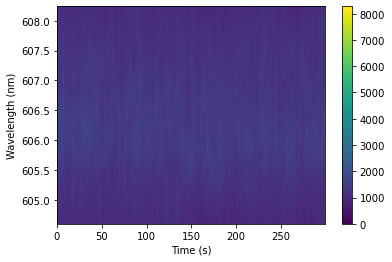

In [49]:
### Pick the first band and apply muti variate to them
# plot the data as an image for a range of wave
df_as_np=df.to_numpy(dtype=np.single)

wave=np.array(df.columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

ss_band1=100
ee_band1=128

plt.pcolor(time, wave[ss_band1:ee_band1], phot.T[ss_band1:ee_band1])
plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
# plt.ylim(ymax = 630, ymin = 618)
plt.show()

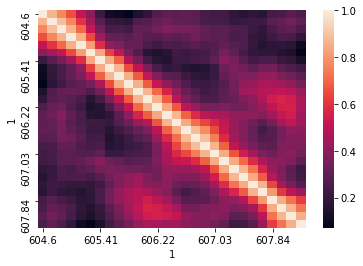

Autocorrelation for 606.49 for 30 lags


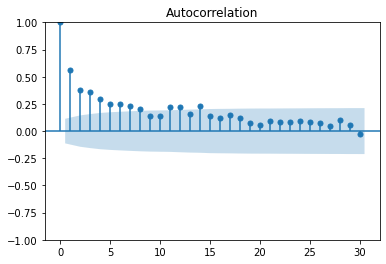

In [289]:
# plot correlation matrix as well as the autocorrelation for the middle wavelegths for band1
corr_auto(df, ss_band1, ee_band1, lags=30, fig_name='band1', ticks=6)

In [51]:
X_train_band1_norm , Y_train_band1_norm , X_val_band1_norm , Y_val_band1_norm , X_test_band1_norm , Y_test_band1_norm, Y_test_band1, X_train_band1=df_to_X_Y_band(df, window_size=5, ss=ss_band1, ee=ee_band1)
X_train_band1_norm.shape , Y_train_band1_norm.shape , X_val_band1_norm.shape , Y_val_band1_norm.shape , X_test_band1_norm.shape , Y_test_band1_norm.shape

((235, 5, 28), (235, 28), (31, 5, 28), (31, 28), (30, 5, 28), (30, 28))

In [56]:
cp_band1=ModelCheckpoint('model/publish2/band/band1/' , save_best_only=True) # it saves the best model based on val error
model_band1=pred_model(X_train_band1_norm, Y_train_band1_norm, batch_size=1)
model_band1.fit(X_train_band1_norm, Y_train_band1_norm, validation_data=(X_val_band1_norm, Y_val_band1_norm), batch_size=1, epochs=200, callbacks=[cp_band1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (1, 128)                  80384     
                                                                 
 dense_6 (Dense)             (1, 20)                   2580      
                                                                 
 dense_7 (Dense)             (1, 28)                   588       
                                                                 
Total params: 83,552
Trainable params: 83,552
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
219/235 [==========================>...] - ETA: 0s - loss: 0.5817 - root_mean_squared_error: 0.7627

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 11s 40ms/step - loss: 0.5714 - root_mean_squared_error: 0.7559 - val_loss: 0.4068 - val_root_mean_squared_error: 0.6378
Epoch 2/200
224/235 [===========================>..] - ETA: 0s - loss: 0.3400 - root_mean_squared_error: 0.5831

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 37ms/step - loss: 0.3364 - root_mean_squared_error: 0.5800 - val_loss: 0.3182 - val_root_mean_squared_error: 0.5641
Epoch 3/200
216/235 [==========================>...] - ETA: 0s - loss: 0.2568 - root_mean_squared_error: 0.5068

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.2548 - root_mean_squared_error: 0.5048 - val_loss: 0.2497 - val_root_mean_squared_error: 0.4997
Epoch 4/200
224/235 [===========================>..] - ETA: 0s - loss: 0.2286 - root_mean_squared_error: 0.4782

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 8s 35ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803 - val_loss: 0.2416 - val_root_mean_squared_error: 0.4915
Epoch 5/200
221/235 [===========================>..] - ETA: 0s - loss: 0.2217 - root_mean_squared_error: 0.4708

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713 - val_loss: 0.2385 - val_root_mean_squared_error: 0.4883
Epoch 6/200
231/235 [============================>.] - ETA: 0s - loss: 0.2189 - root_mean_squared_error: 0.4679

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.2183 - root_mean_squared_error: 0.4672 - val_loss: 0.2333 - val_root_mean_squared_error: 0.4830
Epoch 7/200
235/235 [==============================] - ETA: 0s - loss: 0.2168 - root_mean_squared_error: 0.4656

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656 - val_loss: 0.2251 - val_root_mean_squared_error: 0.4744
Epoch 8/200
235/235 [==============================] - 1s 3ms/step - loss: 0.2134 - root_mean_squared_error: 0.4619 - val_loss: 0.2306 - val_root_mean_squared_error: 0.4802
Epoch 9/200
226/235 [===========================>..] - ETA: 0s - loss: 0.2112 - root_mean_squared_error: 0.4596

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.2122 - root_mean_squared_error: 0.4607 - val_loss: 0.2213 - val_root_mean_squared_error: 0.4704
Epoch 10/200
235/235 [==============================] - 1s 3ms/step - loss: 0.2102 - root_mean_squared_error: 0.4584 - val_loss: 0.2259 - val_root_mean_squared_error: 0.4753
Epoch 11/200
235/235 [==============================] - 1s 3ms/step - loss: 0.2092 - root_mean_squared_error: 0.4574 - val_loss: 0.2216 - val_root_mean_squared_error: 0.4707
Epoch 12/200
214/235 [==========================>...] - ETA: 0s - loss: 0.2071 - root_mean_squared_error: 0.4551

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 8s 36ms/step - loss: 0.2065 - root_mean_squared_error: 0.4545 - val_loss: 0.2114 - val_root_mean_squared_error: 0.4598
Epoch 13/200
235/235 [==============================] - 1s 3ms/step - loss: 0.2055 - root_mean_squared_error: 0.4534 - val_loss: 0.2161 - val_root_mean_squared_error: 0.4649
Epoch 14/200
235/235 [==============================] - 1s 3ms/step - loss: 0.2044 - root_mean_squared_error: 0.4521 - val_loss: 0.2158 - val_root_mean_squared_error: 0.4646
Epoch 15/200
226/235 [===========================>..] - ETA: 0s - loss: 0.2025 - root_mean_squared_error: 0.4500

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.2019 - root_mean_squared_error: 0.4494 - val_loss: 0.2051 - val_root_mean_squared_error: 0.4529
Epoch 16/200
235/235 [==============================] - 1s 3ms/step - loss: 0.2009 - root_mean_squared_error: 0.4482 - val_loss: 0.2077 - val_root_mean_squared_error: 0.4557
Epoch 17/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1991 - root_mean_squared_error: 0.4463 - val_loss: 0.2100 - val_root_mean_squared_error: 0.4583
Epoch 18/200
218/235 [==========================>...] - ETA: 0s - loss: 0.1952 - root_mean_squared_error: 0.4418

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 8s 35ms/step - loss: 0.1976 - root_mean_squared_error: 0.4445 - val_loss: 0.2034 - val_root_mean_squared_error: 0.4510
Epoch 19/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1972 - root_mean_squared_error: 0.4441 - val_loss: 0.2142 - val_root_mean_squared_error: 0.4628
Epoch 20/200
231/235 [============================>.] - ETA: 0s - loss: 0.1945 - root_mean_squared_error: 0.4410

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.1941 - root_mean_squared_error: 0.4405 - val_loss: 0.2033 - val_root_mean_squared_error: 0.4509
Epoch 21/200
234/235 [============================>.] - ETA: 0s - loss: 0.1944 - root_mean_squared_error: 0.4409

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 40ms/step - loss: 0.1948 - root_mean_squared_error: 0.4413 - val_loss: 0.2025 - val_root_mean_squared_error: 0.4500
Epoch 22/200
218/235 [==========================>...] - ETA: 0s - loss: 0.1921 - root_mean_squared_error: 0.4383

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 37ms/step - loss: 0.1927 - root_mean_squared_error: 0.4390 - val_loss: 0.2023 - val_root_mean_squared_error: 0.4498
Epoch 23/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1928 - root_mean_squared_error: 0.4391 - val_loss: 0.2067 - val_root_mean_squared_error: 0.4546
Epoch 24/200
231/235 [============================>.] - ETA: 0s - loss: 0.1906 - root_mean_squared_error: 0.4365

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 8s 33ms/step - loss: 0.1903 - root_mean_squared_error: 0.4362 - val_loss: 0.1973 - val_root_mean_squared_error: 0.4442
Epoch 25/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1907 - root_mean_squared_error: 0.4366 - val_loss: 0.2057 - val_root_mean_squared_error: 0.4536
Epoch 26/200
235/235 [==============================] - 1s 2ms/step - loss: 0.1889 - root_mean_squared_error: 0.4347 - val_loss: 0.2076 - val_root_mean_squared_error: 0.4557
Epoch 27/200
235/235 [==============================] - 1s 2ms/step - loss: 0.1879 - root_mean_squared_error: 0.4335 - val_loss: 0.2021 - val_root_mean_squared_error: 0.4495
Epoch 28/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1862 - root_mean_squared_error: 0.4316 - val_loss: 0.2026 - val_root_mean_squared_error: 0.4501
Epoch 29/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1860 - root_mean_squared_error: 0.4312 - val_loss: 0.2040 - val_

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 8s 36ms/step - loss: 0.1819 - root_mean_squared_error: 0.4265 - val_loss: 0.1954 - val_root_mean_squared_error: 0.4420
Epoch 36/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1784 - root_mean_squared_error: 0.4223 - val_loss: 0.1991 - val_root_mean_squared_error: 0.4462
Epoch 37/200
218/235 [==========================>...] - ETA: 0s - loss: 0.1811 - root_mean_squared_error: 0.4256

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 8s 35ms/step - loss: 0.1793 - root_mean_squared_error: 0.4234 - val_loss: 0.1940 - val_root_mean_squared_error: 0.4404
Epoch 38/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1796 - root_mean_squared_error: 0.4238 - val_loss: 0.2018 - val_root_mean_squared_error: 0.4492
Epoch 39/200
225/235 [===========================>..] - ETA: 0s - loss: 0.1792 - root_mean_squared_error: 0.4233

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 8s 36ms/step - loss: 0.1772 - root_mean_squared_error: 0.4210 - val_loss: 0.1908 - val_root_mean_squared_error: 0.4368
Epoch 40/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1776 - root_mean_squared_error: 0.4214 - val_loss: 0.1934 - val_root_mean_squared_error: 0.4397
Epoch 41/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1771 - root_mean_squared_error: 0.4209 - val_loss: 0.1919 - val_root_mean_squared_error: 0.4381
Epoch 42/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1749 - root_mean_squared_error: 0.4182 - val_loss: 0.2046 - val_root_mean_squared_error: 0.4524
Epoch 43/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195 - val_loss: 0.2072 - val_root_mean_squared_error: 0.4552
Epoch 44/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1740 - root_mean_squared_error: 0.4171 - val_loss: 0.2041 - val_

INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


INFO:tensorflow:Assets written to: model/publish2/band/band1\assets


235/235 [==============================] - 9s 37ms/step - loss: 0.1669 - root_mean_squared_error: 0.4085 - val_loss: 0.1898 - val_root_mean_squared_error: 0.4357
Epoch 56/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1658 - root_mean_squared_error: 0.4071 - val_loss: 0.1999 - val_root_mean_squared_error: 0.4471
Epoch 57/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1637 - root_mean_squared_error: 0.4045 - val_loss: 0.1922 - val_root_mean_squared_error: 0.4384
Epoch 58/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1625 - root_mean_squared_error: 0.4031 - val_loss: 0.1906 - val_root_mean_squared_error: 0.4365
Epoch 59/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1634 - root_mean_squared_error: 0.4042 - val_loss: 0.1968 - val_root_mean_squared_error: 0.4436
Epoch 60/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1620 - root_mean_squared_error: 0.4025 - val_loss: 0.1969 - val_

235/235 [==============================] - 1s 3ms/step - loss: 0.1289 - root_mean_squared_error: 0.3590 - val_loss: 0.2071 - val_root_mean_squared_error: 0.4551
Epoch 103/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1266 - root_mean_squared_error: 0.3558 - val_loss: 0.2037 - val_root_mean_squared_error: 0.4514
Epoch 104/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1263 - root_mean_squared_error: 0.3553 - val_loss: 0.2065 - val_root_mean_squared_error: 0.4544
Epoch 105/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1243 - root_mean_squared_error: 0.3526 - val_loss: 0.2070 - val_root_mean_squared_error: 0.4550
Epoch 106/200
235/235 [==============================] - 1s 4ms/step - loss: 0.1247 - root_mean_squared_error: 0.3531 - val_loss: 0.2061 - val_root_mean_squared_error: 0.4540
Epoch 107/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1235 - root_mean_squared_error: 0.3514 - val_loss: 0.2031 - 

Epoch 149/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0923 - root_mean_squared_error: 0.3039 - val_loss: 0.2232 - val_root_mean_squared_error: 0.4724
Epoch 150/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0932 - root_mean_squared_error: 0.3052 - val_loss: 0.2296 - val_root_mean_squared_error: 0.4792
Epoch 151/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0942 - root_mean_squared_error: 0.3069 - val_loss: 0.2306 - val_root_mean_squared_error: 0.4802
Epoch 152/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0927 - root_mean_squared_error: 0.3045 - val_loss: 0.2256 - val_root_mean_squared_error: 0.4749
Epoch 153/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0917 - root_mean_squared_error: 0.3027 - val_loss: 0.2284 - val_root_mean_squared_error: 0.4779
Epoch 154/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0901 - root_mean_squared_error: 0.3001 - val_l

Epoch 196/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0679 - root_mean_squared_error: 0.2605 - val_loss: 0.2326 - val_root_mean_squared_error: 0.4823
Epoch 197/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0674 - root_mean_squared_error: 0.2595 - val_loss: 0.2298 - val_root_mean_squared_error: 0.4794
Epoch 198/200
235/235 [==============================] - 1s 4ms/step - loss: 0.0679 - root_mean_squared_error: 0.2605 - val_loss: 0.2315 - val_root_mean_squared_error: 0.4811
Epoch 199/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0671 - root_mean_squared_error: 0.2590 - val_loss: 0.2378 - val_root_mean_squared_error: 0.4877
Epoch 200/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0671 - root_mean_squared_error: 0.2591 - val_loss: 0.2343 - val_root_mean_squared_error: 0.4841


rmse for 606.08 is: 88.92344319713823
Total rmse over test set using prediction model is :76.25619785211987


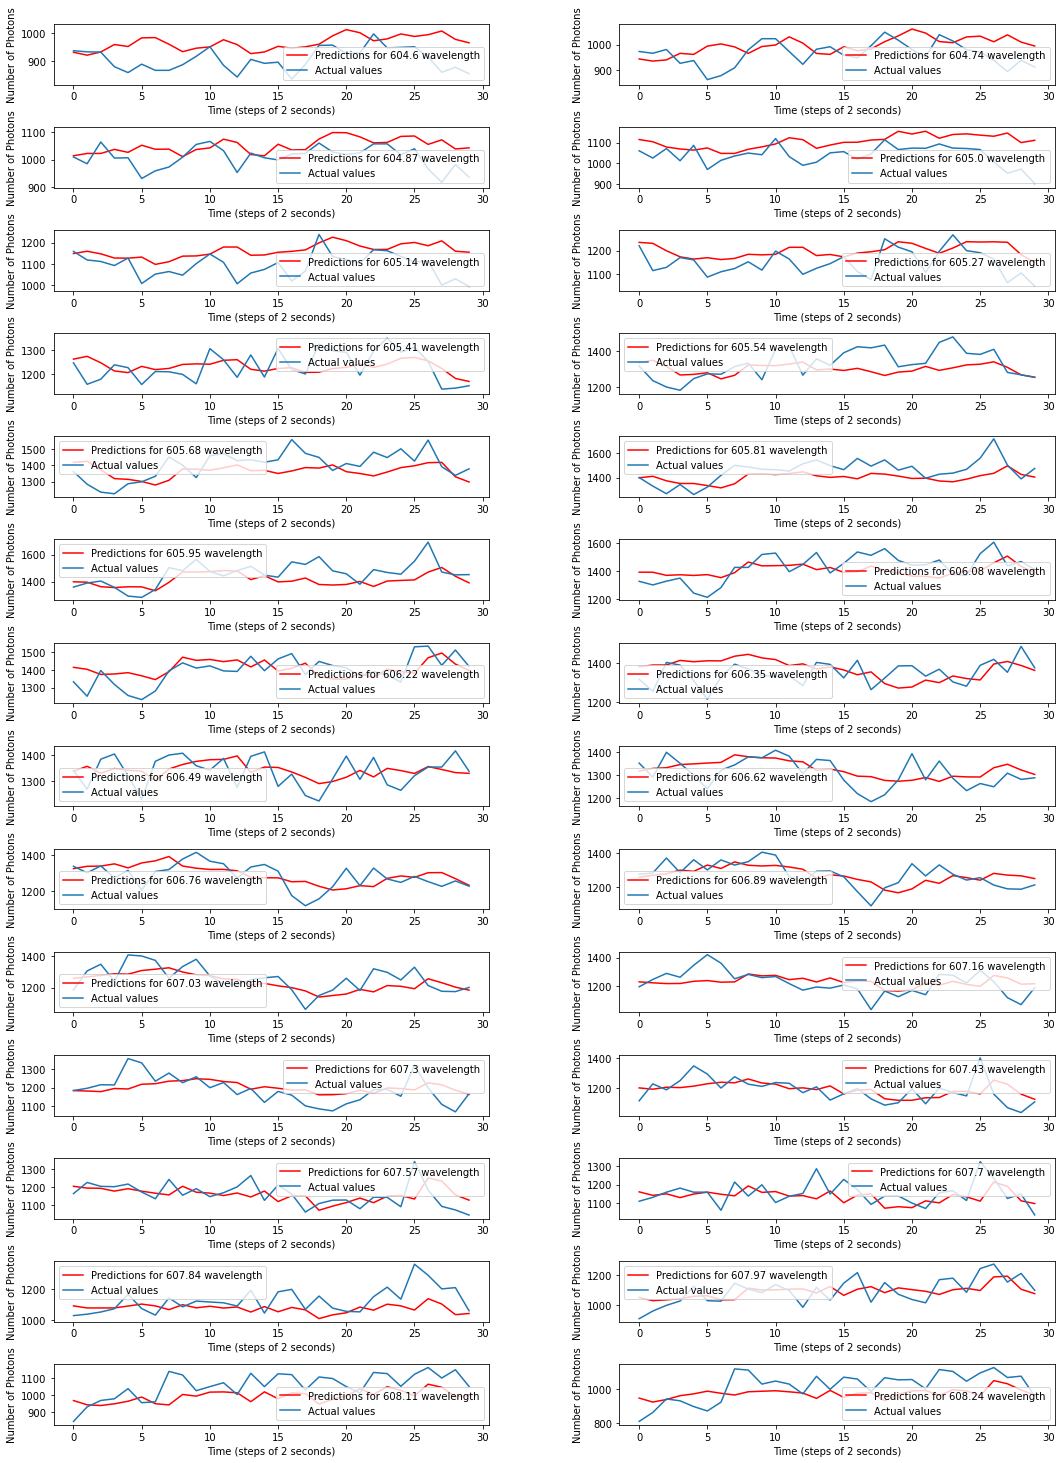

In [157]:
### plot the predictions and actual values as images 
# load the trained model
model_band1=tf.keras.models.load_model('model/publish/band/band1/')

plot_predictions_band(model_band=model_band1, X_test_band_norm=X_test_band1_norm, X_train_band=X_train_band1, Y_test_band=Y_test_band1, start=0, end=20 ,ss=ss_band1, ee=ee_band1, wave_to_save=11)

<ipython-input-181-2b0c0634f735>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_band, wave_test_band, Y_test_band.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
<ipython-input-181-2b0c0634f735>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_band, wave_test_band, predictions_actual_band.T) # we can write phot_test_single instead of Y_test_single.image as well as th

Total rmse over test set using prediction model is :76.11946186492894
Total rmse over test set using shifted model is :225.74287374393148


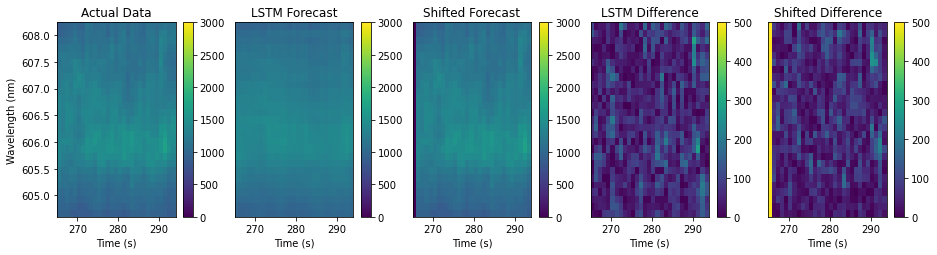

In [186]:
### plot the predictions and actual values as images 

band_image(model_band1, X_test_band1_norm, Y_test_band1, X_train_band1, df_as_np, window_size, ss=ss_band1, ee=ee_band1, thresh1=3000, thresh2=500)
# save the images
path='C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Code/QE_Forecast/Figs/'
plt.savefig(path + 'band1_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))

#### Band 2

<ipython-input-59-c78bc9a49056>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time, wave[ss_band2:ee_band2], phot.T[ss_band2:ee_band2])


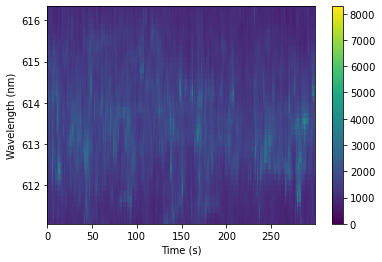

In [59]:
### Pick the first band and apply muti variate to them
# plot the data as an image for a range of wave

wave=np.array(df.columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

ss_band2=148
ee_band2=188

plt.pcolor(time, wave[ss_band2:ee_band2], phot.T[ss_band2:ee_band2])
plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
# plt.ylim(ymax = 630, ymin = 618)
plt.show()

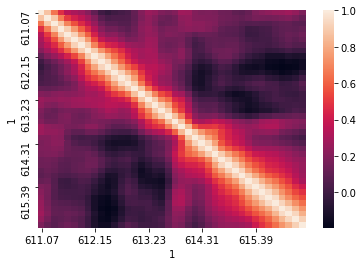

Autocorrelation for 613.77 for 30 lags


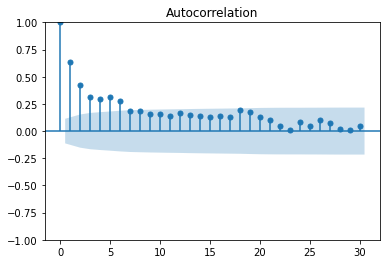

In [290]:
# plot correlation matrix as well as the autocorrelation for the middle wavelegths for band2
corr_auto(df, ss_band2, ee_band2, lags=30, fig_name='band2', ticks=8)

In [61]:
X_train_band2_norm , Y_train_band2_norm , X_val_band2_norm , Y_val_band2_norm , X_test_band2_norm , Y_test_band2_norm, Y_test_band2, X_train_band2=df_to_X_Y_band(df, window_size, ss=ss_band2, ee=ee_band2)
X_train_band2_norm.shape , Y_train_band2_norm.shape , X_val_band2_norm.shape , Y_val_band2_norm.shape , X_test_band2_norm.shape , Y_test_band2_norm.shape

((235, 5, 40), (235, 40), (31, 5, 40), (31, 40), (30, 5, 40), (30, 40))

In [62]:
cp_band2=ModelCheckpoint('model/publish2/band/band2/' , save_best_only=True) # it saves the best model based on val error
model_band2=pred_model(X_train_band2_norm, Y_train_band2_norm, batch_size=1)
model_band2.fit(X_train_band2_norm, Y_train_band2_norm, validation_data=(X_val_band2_norm, Y_val_band2_norm), batch_size=1, epochs=1700, callbacks=[cp_band2])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 128)                  86528     
                                                                 
 dense_8 (Dense)             (1, 20)                   2580      
                                                                 
 dense_9 (Dense)             (1, 40)                   840       
                                                                 
Total params: 89,948
Trainable params: 89,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1700
233/235 [============================>.] - ETA: 0s - loss: 0.7998 - root_mean_squared_error: 0.8943

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 11s 42ms/step - loss: 0.8036 - root_mean_squared_error: 0.8965 - val_loss: 1.1134 - val_root_mean_squared_error: 1.0552
Epoch 2/1700
218/235 [==========================>...] - ETA: 0s - loss: 0.6457 - root_mean_squared_error: 0.8036

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.6376 - root_mean_squared_error: 0.7985 - val_loss: 0.8764 - val_root_mean_squared_error: 0.9361
Epoch 3/1700
226/235 [===========================>..] - ETA: 0s - loss: 0.5508 - root_mean_squared_error: 0.7422

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.5487 - root_mean_squared_error: 0.7407 - val_loss: 0.7367 - val_root_mean_squared_error: 0.8583
Epoch 4/1700
218/235 [==========================>...] - ETA: 0s - loss: 0.4864 - root_mean_squared_error: 0.6974

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.5006 - root_mean_squared_error: 0.7076 - val_loss: 0.6600 - val_root_mean_squared_error: 0.8124
Epoch 5/1700
217/235 [==========================>...] - ETA: 0s - loss: 0.4768 - root_mean_squared_error: 0.6905

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.4710 - root_mean_squared_error: 0.6863 - val_loss: 0.6177 - val_root_mean_squared_error: 0.7860
Epoch 6/1700
227/235 [===========================>..] - ETA: 0s - loss: 0.4557 - root_mean_squared_error: 0.6750

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 8s 35ms/step - loss: 0.4529 - root_mean_squared_error: 0.6730 - val_loss: 0.5508 - val_root_mean_squared_error: 0.7421
Epoch 7/1700
219/235 [==========================>...] - ETA: 0s - loss: 0.4379 - root_mean_squared_error: 0.6617

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 10s 41ms/step - loss: 0.4386 - root_mean_squared_error: 0.6623 - val_loss: 0.5428 - val_root_mean_squared_error: 0.7367
Epoch 8/1700
225/235 [===========================>..] - ETA: 0s - loss: 0.4210 - root_mean_squared_error: 0.6488

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 8s 34ms/step - loss: 0.4260 - root_mean_squared_error: 0.6527 - val_loss: 0.5352 - val_root_mean_squared_error: 0.7316
Epoch 9/1700
218/235 [==========================>...] - ETA: 0s - loss: 0.4175 - root_mean_squared_error: 0.6461

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 8s 36ms/step - loss: 0.4144 - root_mean_squared_error: 0.6437 - val_loss: 0.5128 - val_root_mean_squared_error: 0.7161
Epoch 10/1700
232/235 [============================>.] - ETA: 0s - loss: 0.4040 - root_mean_squared_error: 0.6356

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 11s 45ms/step - loss: 0.4046 - root_mean_squared_error: 0.6361 - val_loss: 0.5112 - val_root_mean_squared_error: 0.7150
Epoch 11/1700
214/235 [==========================>...] - ETA: 0s - loss: 0.3913 - root_mean_squared_error: 0.6255

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 8s 36ms/step - loss: 0.3937 - root_mean_squared_error: 0.6275 - val_loss: 0.5090 - val_root_mean_squared_error: 0.7134
Epoch 12/1700
224/235 [===========================>..] - ETA: 0s - loss: 0.3800 - root_mean_squared_error: 0.6164

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 8s 36ms/step - loss: 0.3854 - root_mean_squared_error: 0.6208 - val_loss: 0.4722 - val_root_mean_squared_error: 0.6872
Epoch 13/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.3784 - root_mean_squared_error: 0.6151 - val_loss: 0.4829 - val_root_mean_squared_error: 0.6949
Epoch 14/1700
235/235 [==============================] - 1s 2ms/step - loss: 0.3697 - root_mean_squared_error: 0.6081 - val_loss: 0.4835 - val_root_mean_squared_error: 0.6954
Epoch 15/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.3620 - root_mean_squared_error: 0.6017 - val_loss: 0.4811 - val_root_mean_squared_error: 0.6936
Epoch 16/1700
228/235 [============================>.] - ETA: 0s - loss: 0.3615 - root_mean_squared_error: 0.6012

INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


INFO:tensorflow:Assets written to: model/publish2/band/band2\assets


235/235 [==============================] - 9s 37ms/step - loss: 0.3591 - root_mean_squared_error: 0.5992 - val_loss: 0.4425 - val_root_mean_squared_error: 0.6652
Epoch 17/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.3495 - root_mean_squared_error: 0.5912 - val_loss: 0.4635 - val_root_mean_squared_error: 0.6808
Epoch 18/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.3446 - root_mean_squared_error: 0.5870 - val_loss: 0.4752 - val_root_mean_squared_error: 0.6893
Epoch 19/1700
235/235 [==============================] - 1s 2ms/step - loss: 0.3407 - root_mean_squared_error: 0.5837 - val_loss: 0.4765 - val_root_mean_squared_error: 0.6903
Epoch 20/1700
235/235 [==============================] - 1s 2ms/step - loss: 0.3363 - root_mean_squared_error: 0.5799 - val_loss: 0.4769 - val_root_mean_squared_error: 0.6906
Epoch 21/1700
235/235 [==============================] - 1s 2ms/step - loss: 0.3295 - root_mean_squared_error: 0.5740 - val_loss: 0.4739 -

Epoch 63/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.2110 - root_mean_squared_error: 0.4594 - val_loss: 0.5064 - val_root_mean_squared_error: 0.7116
Epoch 64/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.2083 - root_mean_squared_error: 0.4564 - val_loss: 0.5040 - val_root_mean_squared_error: 0.7100
Epoch 65/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539 - val_loss: 0.5298 - val_root_mean_squared_error: 0.7279
Epoch 66/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.2036 - root_mean_squared_error: 0.4513 - val_loss: 0.4772 - val_root_mean_squared_error: 0.6908
Epoch 67/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.2028 - root_mean_squared_error: 0.4503 - val_loss: 0.5032 - val_root_mean_squared_error: 0.7094
Epoch 68/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.1988 - root_mean_squared_error: 0.4458 - val_l

Epoch 110/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.1363 - root_mean_squared_error: 0.3691 - val_loss: 0.5696 - val_root_mean_squared_error: 0.7547
Epoch 111/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.1342 - root_mean_squared_error: 0.3664 - val_loss: 0.5666 - val_root_mean_squared_error: 0.7527
Epoch 112/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - val_loss: 0.5558 - val_root_mean_squared_error: 0.7455
Epoch 113/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.1327 - root_mean_squared_error: 0.3643 - val_loss: 0.5634 - val_root_mean_squared_error: 0.7506
Epoch 114/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.1316 - root_mean_squared_error: 0.3627 - val_loss: 0.5687 - val_root_mean_squared_error: 0.7541
Epoch 115/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.1300 - root_mean_squared_error: 0.3605 -

235/235 [==============================] - 1s 3ms/step - loss: 0.0921 - root_mean_squared_error: 0.3035 - val_loss: 0.6478 - val_root_mean_squared_error: 0.8049
Epoch 157/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0908 - root_mean_squared_error: 0.3014 - val_loss: 0.6357 - val_root_mean_squared_error: 0.7973
Epoch 158/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0916 - root_mean_squared_error: 0.3027 - val_loss: 0.6661 - val_root_mean_squared_error: 0.8162
Epoch 159/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0902 - root_mean_squared_error: 0.3004 - val_loss: 0.6280 - val_root_mean_squared_error: 0.7925
Epoch 160/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0892 - root_mean_squared_error: 0.2986 - val_loss: 0.6616 - val_root_mean_squared_error: 0.8134
Epoch 161/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0884 - root_mean_squared_error: 0.2973 - val_loss: 0.64

235/235 [==============================] - 1s 3ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563 - val_loss: 0.6706 - val_root_mean_squared_error: 0.8189
Epoch 203/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0651 - root_mean_squared_error: 0.2552 - val_loss: 0.6567 - val_root_mean_squared_error: 0.8104
Epoch 204/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0659 - root_mean_squared_error: 0.2568 - val_loss: 0.6527 - val_root_mean_squared_error: 0.8079
Epoch 205/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0643 - root_mean_squared_error: 0.2535 - val_loss: 0.6607 - val_root_mean_squared_error: 0.8129
Epoch 206/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0643 - root_mean_squared_error: 0.2535 - val_loss: 0.6564 - val_root_mean_squared_error: 0.8102
Epoch 207/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0650 - root_mean_squared_error: 0.2549 - val_loss: 0.65

235/235 [==============================] - 1s 2ms/step - loss: 0.0495 - root_mean_squared_error: 0.2225 - val_loss: 0.6774 - val_root_mean_squared_error: 0.8231
Epoch 249/1700
235/235 [==============================] - 1s 2ms/step - loss: 0.0502 - root_mean_squared_error: 0.2240 - val_loss: 0.6793 - val_root_mean_squared_error: 0.8242
Epoch 250/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0495 - root_mean_squared_error: 0.2224 - val_loss: 0.6854 - val_root_mean_squared_error: 0.8279
Epoch 251/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0495 - root_mean_squared_error: 0.2225 - val_loss: 0.6804 - val_root_mean_squared_error: 0.8248
Epoch 252/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0487 - root_mean_squared_error: 0.2207 - val_loss: 0.6824 - val_root_mean_squared_error: 0.8261
Epoch 253/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0485 - root_mean_squared_error: 0.2201 - val_loss: 0.66

235/235 [==============================] - 1s 3ms/step - loss: 0.0393 - root_mean_squared_error: 0.1983 - val_loss: 0.6704 - val_root_mean_squared_error: 0.8188
Epoch 295/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0387 - root_mean_squared_error: 0.1967 - val_loss: 0.6776 - val_root_mean_squared_error: 0.8231
Epoch 296/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0388 - root_mean_squared_error: 0.1971 - val_loss: 0.6658 - val_root_mean_squared_error: 0.8160
Epoch 297/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0390 - root_mean_squared_error: 0.1974 - val_loss: 0.6702 - val_root_mean_squared_error: 0.8186
Epoch 298/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - val_loss: 0.6742 - val_root_mean_squared_error: 0.8211
Epoch 299/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0383 - root_mean_squared_error: 0.1956 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0315 - root_mean_squared_error: 0.1776 - val_loss: 0.6463 - val_root_mean_squared_error: 0.8039
Epoch 341/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0316 - root_mean_squared_error: 0.1777 - val_loss: 0.6581 - val_root_mean_squared_error: 0.8112
Epoch 342/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0315 - root_mean_squared_error: 0.1776 - val_loss: 0.6574 - val_root_mean_squared_error: 0.8108
Epoch 343/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0318 - root_mean_squared_error: 0.1782 - val_loss: 0.6740 - val_root_mean_squared_error: 0.8210
Epoch 344/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0315 - root_mean_squared_error: 0.1776 - val_loss: 0.6651 - val_root_mean_squared_error: 0.8155
Epoch 345/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0313 - root_mean_squared_error: 0.1768 - val_loss: 0.64

235/235 [==============================] - 1s 3ms/step - loss: 0.0268 - root_mean_squared_error: 0.1637 - val_loss: 0.6384 - val_root_mean_squared_error: 0.7990
Epoch 387/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0266 - root_mean_squared_error: 0.1632 - val_loss: 0.6291 - val_root_mean_squared_error: 0.7932
Epoch 388/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0268 - root_mean_squared_error: 0.1636 - val_loss: 0.6421 - val_root_mean_squared_error: 0.8013
Epoch 389/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0267 - root_mean_squared_error: 0.1633 - val_loss: 0.6346 - val_root_mean_squared_error: 0.7966
Epoch 390/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628 - val_loss: 0.6363 - val_root_mean_squared_error: 0.7977
Epoch 391/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0262 - root_mean_squared_error: 0.1618 - val_loss: 0.62

235/235 [==============================] - 1s 3ms/step - loss: 0.0235 - root_mean_squared_error: 0.1532 - val_loss: 0.6185 - val_root_mean_squared_error: 0.7864
Epoch 433/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.6281 - val_root_mean_squared_error: 0.7925
Epoch 434/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0233 - root_mean_squared_error: 0.1527 - val_loss: 0.6306 - val_root_mean_squared_error: 0.7941
Epoch 435/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0231 - root_mean_squared_error: 0.1519 - val_loss: 0.6267 - val_root_mean_squared_error: 0.7916
Epoch 436/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.6347 - val_root_mean_squared_error: 0.7967
Epoch 437/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.61

235/235 [==============================] - 1s 3ms/step - loss: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.6104 - val_root_mean_squared_error: 0.7813
Epoch 479/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0209 - root_mean_squared_error: 0.1445 - val_loss: 0.6136 - val_root_mean_squared_error: 0.7833
Epoch 480/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1440 - val_loss: 0.6140 - val_root_mean_squared_error: 0.7836
Epoch 481/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0208 - root_mean_squared_error: 0.1442 - val_loss: 0.6098 - val_root_mean_squared_error: 0.7809
Epoch 482/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443 - val_loss: 0.6063 - val_root_mean_squared_error: 0.7787
Epoch 483/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1438 - val_loss: 0.61

235/235 [==============================] - 1s 5ms/step - loss: 0.0191 - root_mean_squared_error: 0.1384 - val_loss: 0.5938 - val_root_mean_squared_error: 0.7706
Epoch 525/1700
235/235 [==============================] - 1s 5ms/step - loss: 0.0191 - root_mean_squared_error: 0.1382 - val_loss: 0.5983 - val_root_mean_squared_error: 0.7735
Epoch 526/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.5998 - val_root_mean_squared_error: 0.7744
Epoch 527/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384 - val_loss: 0.5944 - val_root_mean_squared_error: 0.7710
Epoch 528/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0191 - root_mean_squared_error: 0.1382 - val_loss: 0.6016 - val_root_mean_squared_error: 0.7756
Epoch 529/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385 - val_loss: 0.60

235/235 [==============================] - 1s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.5956 - val_root_mean_squared_error: 0.7718
Epoch 571/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.5789 - val_root_mean_squared_error: 0.7609
Epoch 572/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0179 - root_mean_squared_error: 0.1336 - val_loss: 0.5854 - val_root_mean_squared_error: 0.7651
Epoch 573/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.5816 - val_root_mean_squared_error: 0.7627
Epoch 574/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.5810 - val_root_mean_squared_error: 0.7622
Epoch 575/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1336 - val_loss: 0.58

235/235 [==============================] - 1s 3ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.5781 - val_root_mean_squared_error: 0.7603
Epoch 617/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0169 - root_mean_squared_error: 0.1300 - val_loss: 0.5691 - val_root_mean_squared_error: 0.7544
Epoch 618/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0169 - root_mean_squared_error: 0.1302 - val_loss: 0.5781 - val_root_mean_squared_error: 0.7603
Epoch 619/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.5747 - val_root_mean_squared_error: 0.7581
Epoch 620/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.5750 - val_root_mean_squared_error: 0.7583
Epoch 621/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.56

235/235 [==============================] - 1s 3ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.5636 - val_root_mean_squared_error: 0.7508
Epoch 663/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0162 - root_mean_squared_error: 0.1271 - val_loss: 0.5681 - val_root_mean_squared_error: 0.7537
Epoch 664/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.5643 - val_root_mean_squared_error: 0.7512
Epoch 665/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.5679 - val_root_mean_squared_error: 0.7536
Epoch 666/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269 - val_loss: 0.5683 - val_root_mean_squared_error: 0.7539
Epoch 667/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.56

235/235 [==============================] - 1s 4ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.5515 - val_root_mean_squared_error: 0.7426
Epoch 709/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.5548 - val_root_mean_squared_error: 0.7449
Epoch 710/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0154 - root_mean_squared_error: 0.1239 - val_loss: 0.5538 - val_root_mean_squared_error: 0.7442
Epoch 711/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0153 - root_mean_squared_error: 0.1238 - val_loss: 0.5596 - val_root_mean_squared_error: 0.7480
Epoch 712/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.5569 - val_root_mean_squared_error: 0.7463
Epoch 713/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244 - val_loss: 0.55

235/235 [==============================] - 1s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.5447 - val_root_mean_squared_error: 0.7380
Epoch 755/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1216 - val_loss: 0.5545 - val_root_mean_squared_error: 0.7447
Epoch 756/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.5506 - val_root_mean_squared_error: 0.7420
Epoch 757/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0147 - root_mean_squared_error: 0.1212 - val_loss: 0.5568 - val_root_mean_squared_error: 0.7462
Epoch 758/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.5504 - val_root_mean_squared_error: 0.7419
Epoch 759/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0150 - root_mean_squared_error: 0.1226 - val_loss: 0.54

235/235 [==============================] - 1s 3ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.5440 - val_root_mean_squared_error: 0.7375
Epoch 801/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.5433 - val_root_mean_squared_error: 0.7371
Epoch 802/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.5394 - val_root_mean_squared_error: 0.7344
Epoch 803/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.5512 - val_root_mean_squared_error: 0.7424
Epoch 804/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1199 - val_loss: 0.5431 - val_root_mean_squared_error: 0.7369
Epoch 805/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1198 - val_loss: 0.54

235/235 [==============================] - 1s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1189 - val_loss: 0.5344 - val_root_mean_squared_error: 0.7310
Epoch 847/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.5380 - val_root_mean_squared_error: 0.7335
Epoch 848/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.5326 - val_root_mean_squared_error: 0.7298
Epoch 849/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184 - val_loss: 0.5427 - val_root_mean_squared_error: 0.7367
Epoch 850/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184 - val_loss: 0.5347 - val_root_mean_squared_error: 0.7312
Epoch 851/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0140 - root_mean_squared_error: 0.1183 - val_loss: 0.53

235/235 [==============================] - 1s 3ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.5307 - val_root_mean_squared_error: 0.7285
Epoch 893/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.5267 - val_root_mean_squared_error: 0.7258
Epoch 894/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173 - val_loss: 0.5319 - val_root_mean_squared_error: 0.7293
Epoch 895/1700
235/235 [==============================] - 1s 5ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169 - val_loss: 0.5322 - val_root_mean_squared_error: 0.7295
Epoch 896/1700
235/235 [==============================] - 1s 5ms/step - loss: 0.0137 - root_mean_squared_error: 0.1172 - val_loss: 0.5299 - val_root_mean_squared_error: 0.7280
Epoch 897/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.53

235/235 [==============================] - 1s 3ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167 - val_loss: 0.5306 - val_root_mean_squared_error: 0.7285
Epoch 939/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.5282 - val_root_mean_squared_error: 0.7268
Epoch 940/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0134 - root_mean_squared_error: 0.1160 - val_loss: 0.5209 - val_root_mean_squared_error: 0.7218
Epoch 941/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0134 - root_mean_squared_error: 0.1157 - val_loss: 0.5221 - val_root_mean_squared_error: 0.7226
Epoch 942/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155 - val_loss: 0.5285 - val_root_mean_squared_error: 0.7270
Epoch 943/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.52

235/235 [==============================] - 1s 3ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.5262 - val_root_mean_squared_error: 0.7254
Epoch 985/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.5222 - val_root_mean_squared_error: 0.7226
Epoch 986/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.5269 - val_root_mean_squared_error: 0.7259
Epoch 987/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.5238 - val_root_mean_squared_error: 0.7237
Epoch 988/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155 - val_loss: 0.5267 - val_root_mean_squared_error: 0.7258
Epoch 989/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0135 - root_mean_squared_error: 0.1160 - val_loss: 0.51

235/235 [==============================] - 1s 4ms/step - loss: 0.0131 - root_mean_squared_error: 0.1146 - val_loss: 0.5244 - val_root_mean_squared_error: 0.7242
Epoch 1031/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.5178 - val_root_mean_squared_error: 0.7196
Epoch 1032/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.5235 - val_root_mean_squared_error: 0.7236
Epoch 1033/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0131 - root_mean_squared_error: 0.1142 - val_loss: 0.5219 - val_root_mean_squared_error: 0.7224
Epoch 1034/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.5207 - val_root_mean_squared_error: 0.7216
Epoch 1035/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0130 - root_mean_squared_error: 0.1138 - val_loss: 0.5186 - val_root_mean_squared_error: 0.7202
Epoch 1077/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.5181 - val_root_mean_squared_error: 0.7198
Epoch 1078/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.5214 - val_root_mean_squared_error: 0.7221
Epoch 1079/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0129 - root_mean_squared_error: 0.1138 - val_loss: 0.5186 - val_root_mean_squared_error: 0.7201
Epoch 1080/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.5206 - val_root_mean_squared_error: 0.7215
Epoch 1081/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0129 - root_mean_squared_error: 0.1137 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.5081 - val_root_mean_squared_error: 0.7128
Epoch 1123/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.5141 - val_root_mean_squared_error: 0.7170
Epoch 1124/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.5129 - val_root_mean_squared_error: 0.7162
Epoch 1125/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.5189 - val_root_mean_squared_error: 0.7204
Epoch 1126/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.5167 - val_root_mean_squared_error: 0.7188
Epoch 1127/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0129 - root_mean_squared_error: 0.1135 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.5134 - val_root_mean_squared_error: 0.7165
Epoch 1169/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.5177 - val_root_mean_squared_error: 0.7195
Epoch 1170/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.5163 - val_root_mean_squared_error: 0.7185
Epoch 1171/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1129 - val_loss: 0.5131 - val_root_mean_squared_error: 0.7163
Epoch 1172/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.5118 - val_root_mean_squared_error: 0.7154
Epoch 1173/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.5075 - val_root_mean_squared_error: 0.7124
Epoch 1215/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 0.5086 - val_root_mean_squared_error: 0.7131
Epoch 1216/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.5044 - val_root_mean_squared_error: 0.7102
Epoch 1217/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.5036 - val_root_mean_squared_error: 0.7096
Epoch 1218/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.5161 - val_root_mean_squared_error: 0.7184
Epoch 1219/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.5033 - val_root_mean_squared_error: 0.7094
Epoch 1261/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 0.5030 - val_root_mean_squared_error: 0.7093
Epoch 1262/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.5066 - val_root_mean_squared_error: 0.7118
Epoch 1263/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.5064 - val_root_mean_squared_error: 0.7116
Epoch 1264/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.5146 - val_root_mean_squared_error: 0.7174
Epoch 1265/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.5027 - val_root_mean_squared_error: 0.7090
Epoch 1307/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.5031 - val_root_mean_squared_error: 0.7093
Epoch 1308/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1120 - val_loss: 0.5020 - val_root_mean_squared_error: 0.7085
Epoch 1309/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.5011 - val_root_mean_squared_error: 0.7079
Epoch 1310/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss: 0.5063 - val_root_mean_squared_error: 0.7115
Epoch 1311/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.4996 - val_root_mean_squared_error: 0.7068
Epoch 1353/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.5017 - val_root_mean_squared_error: 0.7083
Epoch 1354/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.5023 - val_root_mean_squared_error: 0.7087
Epoch 1355/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.4992 - val_root_mean_squared_error: 0.7066
Epoch 1356/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.5054 - val_root_mean_squared_error: 0.7109
Epoch 1357/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1115 - val_loss: 0.4952 - val_root_mean_squared_error: 0.7037
Epoch 1399/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1116 - val_loss: 0.5049 - val_root_mean_squared_error: 0.7106
Epoch 1400/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1115 - val_loss: 0.5022 - val_root_mean_squared_error: 0.7086
Epoch 1401/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 0.5012 - val_root_mean_squared_error: 0.7080
Epoch 1402/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.5015 - val_root_mean_squared_error: 0.7082
Epoch 1403/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.5039 - val_root_mean_squared_error: 0.7099
Epoch 1445/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1111 - val_loss: 0.4969 - val_root_mean_squared_error: 0.7049
Epoch 1446/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.4958 - val_root_mean_squared_error: 0.7042
Epoch 1447/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.5000 - val_root_mean_squared_error: 0.7071
Epoch 1448/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.5021 - val_root_mean_squared_error: 0.7086
Epoch 1449/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.5035 - val_root_mean_squared_error: 0.7096
Epoch 1491/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.4988 - val_root_mean_squared_error: 0.7063
Epoch 1492/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.5003 - val_root_mean_squared_error: 0.7074
Epoch 1493/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.4976 - val_root_mean_squared_error: 0.7054
Epoch 1494/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.5036 - val_root_mean_squared_error: 0.7097
Epoch 1495/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.4924 - val_root_mean_squared_error: 0.7017
Epoch 1537/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1103 - val_loss: 0.4969 - val_root_mean_squared_error: 0.7049
Epoch 1538/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.4971 - val_root_mean_squared_error: 0.7051
Epoch 1539/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.4984 - val_root_mean_squared_error: 0.7060
Epoch 1540/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.4982 - val_root_mean_squared_error: 0.7058
Epoch 1541/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.4964 - val_root_mean_squared_error: 0.7045
Epoch 1583/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.4953 - val_root_mean_squared_error: 0.7038
Epoch 1584/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.5018 - val_root_mean_squared_error: 0.7084
Epoch 1585/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0122 - root_mean_squared_error: 0.1102 - val_loss: 0.4961 - val_root_mean_squared_error: 0.7043
Epoch 1586/1700
235/235 [==============================] - 1s 4ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.4944 - val_root_mean_squared_error: 0.7031
Epoch 1587/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.4963 - val_root_mean_squared_error: 0.7045
Epoch 1629/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.4998 - val_root_mean_squared_error: 0.7070
Epoch 1630/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100 - val_loss: 0.4937 - val_root_mean_squared_error: 0.7027
Epoch 1631/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.4956 - val_root_mean_squared_error: 0.7040
Epoch 1632/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.4924 - val_root_mean_squared_error: 0.7017
Epoch 1633/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.4967 - val_root_mean_squared_error: 0.7048
Epoch 1675/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 0.4953 - val_root_mean_squared_error: 0.7037
Epoch 1676/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0119 - root_mean_squared_error: 0.1093 - val_loss: 0.4921 - val_root_mean_squared_error: 0.7015
Epoch 1677/1700
235/235 [==============================] - 1s 5ms/step - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 0.4972 - val_root_mean_squared_error: 0.7051
Epoch 1678/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.4905 - val_root_mean_squared_error: 0.7004
Epoch 1679/1700
235/235 [==============================] - 1s 3ms/step - loss: 0.0120 - root_mean_squared_error: 0.1093 - val_loss:

313.60475904691964

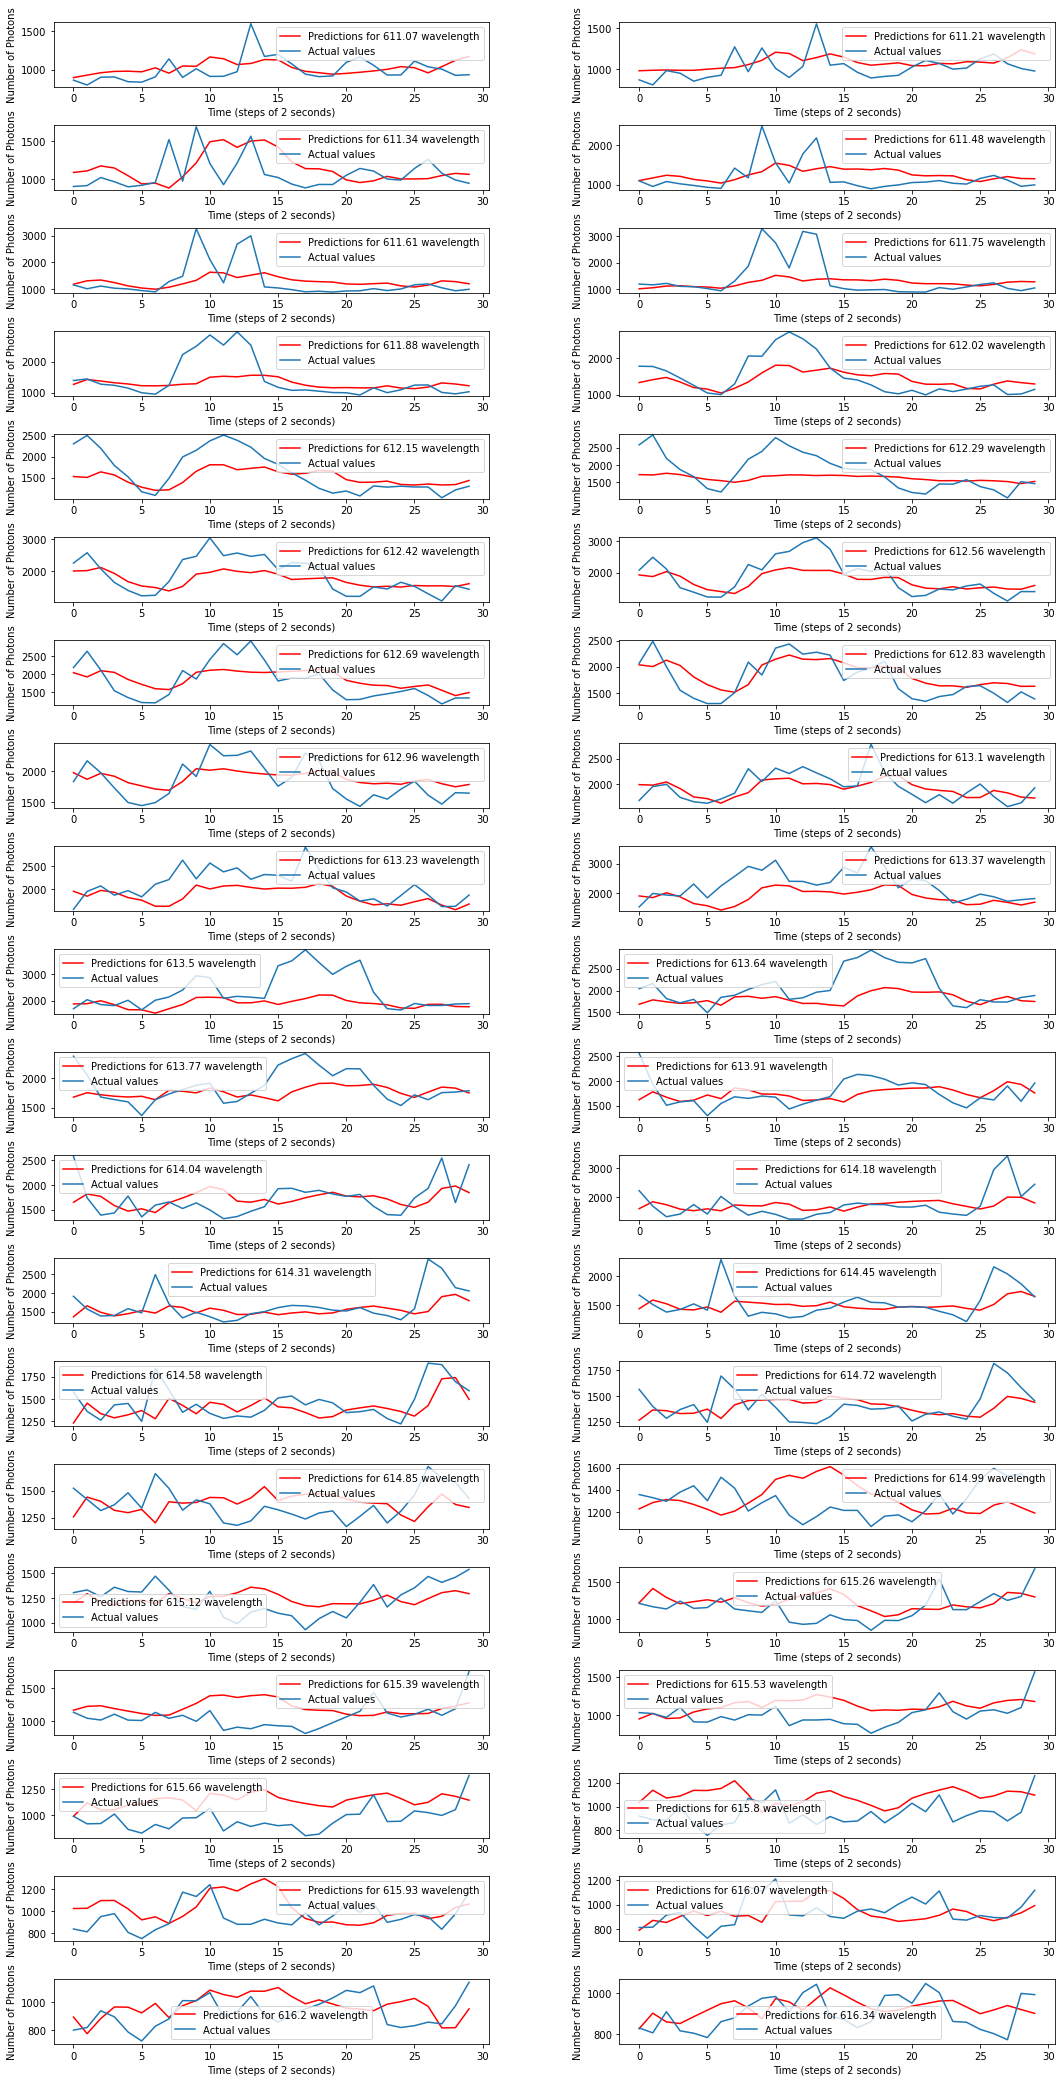

In [106]:
# Plot function and calculate rmse

# load the trained model
# model_band2=tf.keras.models.load_model('model/publish2/band/band2/')
plot_predictions_band(model_band=model_band2, X_test_band_norm=X_test_band2_norm, X_train_band=X_train_band2, Y_test_band=Y_test_band2, start=0, end=20 ,ss=ss_band2, ee=ee_band2, wave_to_save=19)

<ipython-input-181-2b0c0634f735>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_band, wave_test_band, Y_test_band.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
<ipython-input-181-2b0c0634f735>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_band, wave_test_band, predictions_actual_band.T) # we can write phot_test_single instead of Y_test_single.image as well as th

Total rmse over test set using prediction model is :313.6047606261667
Total rmse over test set using shifted model is :387.1886902154937


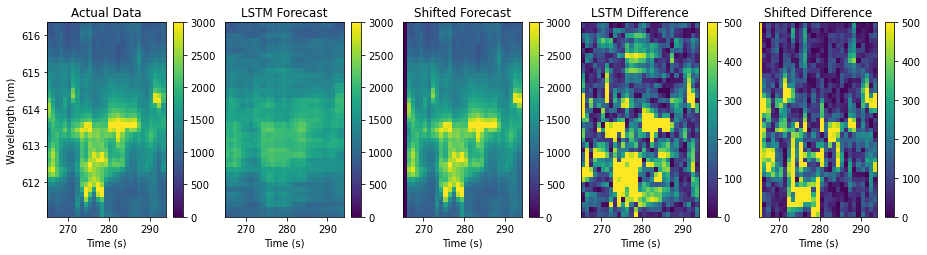

In [187]:
### plot the predictions and actual values as images 

band_image(model_band2, X_test_band2_norm, Y_test_band2, X_train_band2, df_as_np, window_size, ss=ss_band2, ee=ee_band2, thresh1=3000, thresh2=500)
# save the images
path='C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Code/QE_Forecast/Figs/'
plt.savefig(path + 'band2_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))

#### Band 3

<ipython-input-69-f0a8777ad639>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time, wave[ss_band3:ee_band3], phot.T[ss_band3:ee_band3])


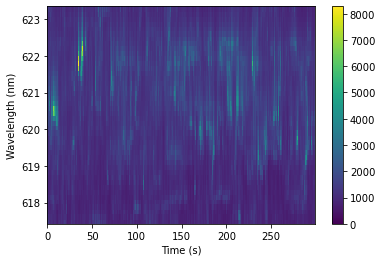

In [69]:
### Pick the third band and apply muti variate to them
# plot the data as an image for a range of wave
df_as_np=df.to_numpy(dtype=np.single)

wave=np.array(df.columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

ss_band3=195 #these are for the third band
ee_band3=240

plt.pcolor(time, wave[ss_band3:ee_band3], phot.T[ss_band3:ee_band3])
plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
# plt.ylim(ymax = 630, ymin = 618)
plt.show()

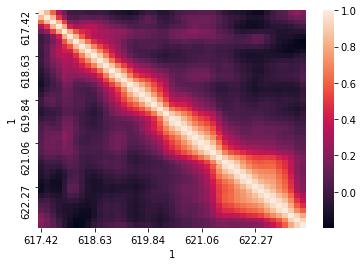

Autocorrelation for 620.38 for 30 lags


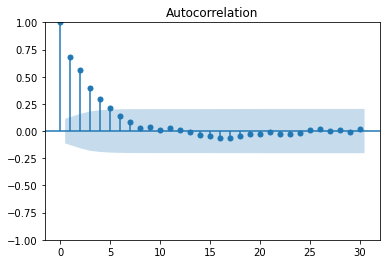

In [293]:
# plot correlation matrix as well as the autocorrelation for the middle wavelegths for band3
corr_auto(df, ss_band3, ee_band3, lags=30, fig_name='band3', ticks=9)

In [71]:
X_train_band3_norm , Y_train_band3_norm , X_val_band3_norm , Y_val_band3_norm , X_test_band3_norm , Y_test_band3_norm, Y_test_band3, X_train_band3=df_to_X_Y_band(df, window_size, ss=ss_band3, ee=ee_band3)
X_train_band3_norm.shape , Y_train_band3_norm.shape , X_val_band3_norm.shape , Y_val_band3_norm.shape , X_test_band3_norm.shape , Y_test_band3_norm.shape

((235, 5, 45), (235, 45), (31, 5, 45), (31, 45), (30, 5, 45), (30, 45))

In [72]:
cp_band3=ModelCheckpoint('model/publish2/band/band3/' , save_best_only=True) # it saves the best model based on val error
model_band3=pred_model(X_train_band3_norm, Y_train_band3_norm, learning_rate=0.00001, batch_size=1)
model_band3.fit(X_train_band3_norm, Y_train_band3_norm, validation_data=(X_val_band3_norm, Y_val_band3_norm), batch_size=1, epochs=1000, callbacks=[cp_band3])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (1, 128)                  89088     
                                                                 
 dense_10 (Dense)            (1, 20)                   2580      
                                                                 
 dense_11 (Dense)            (1, 45)                   945       
                                                                 
Total params: 92,613
Trainable params: 92,613
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
222/235 [===========================>..] - ETA: 0s - loss: 0.9665 - root_mean_squared_error: 0.9831

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 12s 39ms/step - loss: 0.9490 - root_mean_squared_error: 0.9742 - val_loss: 0.8621 - val_root_mean_squared_error: 0.9285
Epoch 2/1000
230/235 [============================>.] - ETA: 0s - loss: 0.8638 - root_mean_squared_error: 0.9294

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.8591 - root_mean_squared_error: 0.9269 - val_loss: 0.7846 - val_root_mean_squared_error: 0.8858
Epoch 3/1000
218/235 [==========================>...] - ETA: 0s - loss: 0.7930 - root_mean_squared_error: 0.8905

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.7812 - root_mean_squared_error: 0.8839 - val_loss: 0.7185 - val_root_mean_squared_error: 0.8476
Epoch 4/1000
218/235 [==========================>...] - ETA: 0s - loss: 0.6920 - root_mean_squared_error: 0.8319

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 8s 35ms/step - loss: 0.7239 - root_mean_squared_error: 0.8508 - val_loss: 0.6764 - val_root_mean_squared_error: 0.8224
Epoch 5/1000
219/235 [==========================>...] - ETA: 0s - loss: 0.6919 - root_mean_squared_error: 0.8318

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.6770 - root_mean_squared_error: 0.8228 - val_loss: 0.6613 - val_root_mean_squared_error: 0.8132
Epoch 6/1000
231/235 [============================>.] - ETA: 0s - loss: 0.6560 - root_mean_squared_error: 0.8099

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.6524 - root_mean_squared_error: 0.8077 - val_loss: 0.6445 - val_root_mean_squared_error: 0.8028
Epoch 7/1000
222/235 [===========================>..] - ETA: 0s - loss: 0.6278 - root_mean_squared_error: 0.7923

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.6301 - root_mean_squared_error: 0.7938 - val_loss: 0.6366 - val_root_mean_squared_error: 0.7979
Epoch 8/1000
233/235 [============================>.] - ETA: 0s - loss: 0.6081 - root_mean_squared_error: 0.7798

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 40ms/step - loss: 0.6127 - root_mean_squared_error: 0.7828 - val_loss: 0.6338 - val_root_mean_squared_error: 0.7961
Epoch 9/1000
216/235 [==========================>...] - ETA: 0s - loss: 0.6096 - root_mean_squared_error: 0.7808

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.6023 - root_mean_squared_error: 0.7761 - val_loss: 0.6325 - val_root_mean_squared_error: 0.7953
Epoch 10/1000
228/235 [============================>.] - ETA: 0s - loss: 0.5942 - root_mean_squared_error: 0.7708

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 12s 52ms/step - loss: 0.5903 - root_mean_squared_error: 0.7683 - val_loss: 0.6295 - val_root_mean_squared_error: 0.7934
Epoch 11/1000
235/235 [==============================] - 1s 6ms/step - loss: 0.5814 - root_mean_squared_error: 0.7625 - val_loss: 0.6308 - val_root_mean_squared_error: 0.7942
Epoch 12/1000
234/235 [============================>.] - ETA: 0s - loss: 0.5727 - root_mean_squared_error: 0.7568

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 17s 71ms/step - loss: 0.5708 - root_mean_squared_error: 0.7555 - val_loss: 0.6266 - val_root_mean_squared_error: 0.7916
Epoch 13/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.5619 - root_mean_squared_error: 0.7496 - val_loss: 0.6269 - val_root_mean_squared_error: 0.7918
Epoch 14/1000
234/235 [============================>.] - ETA: 0s - loss: 0.5517 - root_mean_squared_error: 0.7427

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.5515 - root_mean_squared_error: 0.7426 - val_loss: 0.6247 - val_root_mean_squared_error: 0.7904
Epoch 15/1000
235/235 [==============================] - ETA: 0s - loss: 0.5422 - root_mean_squared_error: 0.7363

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.5422 - root_mean_squared_error: 0.7363 - val_loss: 0.6188 - val_root_mean_squared_error: 0.7866
Epoch 16/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.5389 - root_mean_squared_error: 0.7341 - val_loss: 0.6231 - val_root_mean_squared_error: 0.7894
Epoch 17/1000
227/235 [===========================>..] - ETA: 0s - loss: 0.5179 - root_mean_squared_error: 0.7197

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 8s 35ms/step - loss: 0.5283 - root_mean_squared_error: 0.7268 - val_loss: 0.6174 - val_root_mean_squared_error: 0.7858
Epoch 18/1000
221/235 [===========================>..] - ETA: 0s - loss: 0.5315 - root_mean_squared_error: 0.7291

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.5162 - root_mean_squared_error: 0.7185 - val_loss: 0.6133 - val_root_mean_squared_error: 0.7831
Epoch 19/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.5090 - root_mean_squared_error: 0.7135 - val_loss: 0.6217 - val_root_mean_squared_error: 0.7885
Epoch 20/1000
224/235 [===========================>..] - ETA: 0s - loss: 0.4501 - root_mean_squared_error: 0.6709

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 10s 42ms/step - loss: 0.5071 - root_mean_squared_error: 0.7121 - val_loss: 0.6097 - val_root_mean_squared_error: 0.7809
Epoch 21/1000
228/235 [============================>.] - ETA: 0s - loss: 0.5075 - root_mean_squared_error: 0.7124

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 10s 43ms/step - loss: 0.4990 - root_mean_squared_error: 0.7064 - val_loss: 0.6067 - val_root_mean_squared_error: 0.7789
Epoch 22/1000
230/235 [============================>.] - ETA: 0s - loss: 0.4297 - root_mean_squared_error: 0.6555

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.4927 - root_mean_squared_error: 0.7019 - val_loss: 0.6062 - val_root_mean_squared_error: 0.7786
Epoch 23/1000
229/235 [============================>.] - ETA: 0s - loss: 0.4924 - root_mean_squared_error: 0.7017

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 40ms/step - loss: 0.4853 - root_mean_squared_error: 0.6966 - val_loss: 0.6060 - val_root_mean_squared_error: 0.7784
Epoch 24/1000
216/235 [==========================>...] - ETA: 0s - loss: 0.4962 - root_mean_squared_error: 0.7044

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.4791 - root_mean_squared_error: 0.6922 - val_loss: 0.6005 - val_root_mean_squared_error: 0.7749
Epoch 25/1000
234/235 [============================>.] - ETA: 0s - loss: 0.4728 - root_mean_squared_error: 0.6876

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 40ms/step - loss: 0.4712 - root_mean_squared_error: 0.6864 - val_loss: 0.6004 - val_root_mean_squared_error: 0.7749
Epoch 26/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.4640 - root_mean_squared_error: 0.6812 - val_loss: 0.6030 - val_root_mean_squared_error: 0.7765
Epoch 27/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.4569 - root_mean_squared_error: 0.6759 - val_loss: 0.6005 - val_root_mean_squared_error: 0.7749
Epoch 28/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.4530 - root_mean_squared_error: 0.6730 - val_loss: 0.6013 - val_root_mean_squared_error: 0.7754
Epoch 29/1000
223/235 [===========================>..] - ETA: 0s - loss: 0.4428 - root_mean_squared_error: 0.6655

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.4510 - root_mean_squared_error: 0.6716 - val_loss: 0.5950 - val_root_mean_squared_error: 0.7714
Epoch 30/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.4396 - root_mean_squared_error: 0.6630 - val_loss: 0.5994 - val_root_mean_squared_error: 0.7742
Epoch 31/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.4346 - root_mean_squared_error: 0.6593 - val_loss: 0.5984 - val_root_mean_squared_error: 0.7736
Epoch 32/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.4309 - root_mean_squared_error: 0.6564 - val_loss: 0.6090 - val_root_mean_squared_error: 0.7804
Epoch 33/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.4198 - root_mean_squared_error: 0.6479 - val_loss: 0.6030 - val_root_mean_squared_error: 0.7765
Epoch 34/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.4218 - root_mean_squared_error: 0.6495 - val_loss: 0.6108 -

Epoch 76/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.2595 - root_mean_squared_error: 0.5094 - val_loss: 0.6106 - val_root_mean_squared_error: 0.7814
Epoch 77/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.2553 - root_mean_squared_error: 0.5053 - val_loss: 0.6155 - val_root_mean_squared_error: 0.7846
Epoch 78/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.2578 - root_mean_squared_error: 0.5078 - val_loss: 0.6117 - val_root_mean_squared_error: 0.7821
Epoch 79/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984 - val_loss: 0.6114 - val_root_mean_squared_error: 0.7819
Epoch 80/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.2617 - root_mean_squared_error: 0.5116 - val_loss: 0.6072 - val_root_mean_squared_error: 0.7792
Epoch 81/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.2529 - root_mean_squared_error: 0.5029 - val_l

INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


INFO:tensorflow:Assets written to: model/publish2/band/band3\assets


235/235 [==============================] - 10s 41ms/step - loss: 0.1993 - root_mean_squared_error: 0.4464 - val_loss: 0.5918 - val_root_mean_squared_error: 0.7693
Epoch 113/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1854 - root_mean_squared_error: 0.4306 - val_loss: 0.6040 - val_root_mean_squared_error: 0.7772
Epoch 114/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1771 - root_mean_squared_error: 0.4208 - val_loss: 0.6197 - val_root_mean_squared_error: 0.7872
Epoch 115/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195 - val_loss: 0.6083 - val_root_mean_squared_error: 0.7799
Epoch 116/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1758 - root_mean_squared_error: 0.4193 - val_loss: 0.6049 - val_root_mean_squared_error: 0.7777
Epoch 117/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1761 - root_mean_squared_error: 0.4197 - val_loss: 0.

235/235 [==============================] - 1s 3ms/step - loss: 0.1190 - root_mean_squared_error: 0.3450 - val_loss: 0.6341 - val_root_mean_squared_error: 0.7963
Epoch 159/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1153 - root_mean_squared_error: 0.3395 - val_loss: 0.6291 - val_root_mean_squared_error: 0.7932
Epoch 160/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1149 - root_mean_squared_error: 0.3389 - val_loss: 0.6271 - val_root_mean_squared_error: 0.7919
Epoch 161/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1157 - root_mean_squared_error: 0.3401 - val_loss: 0.6145 - val_root_mean_squared_error: 0.7839
Epoch 162/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1149 - root_mean_squared_error: 0.3390 - val_loss: 0.6210 - val_root_mean_squared_error: 0.7880
Epoch 163/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.1135 - root_mean_squared_error: 0.3370 - val_loss: 0.62

235/235 [==============================] - 1s 3ms/step - loss: 0.0822 - root_mean_squared_error: 0.2867 - val_loss: 0.6109 - val_root_mean_squared_error: 0.7816
Epoch 205/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0796 - root_mean_squared_error: 0.2822 - val_loss: 0.6032 - val_root_mean_squared_error: 0.7766
Epoch 206/1000
235/235 [==============================] - 1s 4ms/step - loss: 0.0795 - root_mean_squared_error: 0.2819 - val_loss: 0.6228 - val_root_mean_squared_error: 0.7892
Epoch 207/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0786 - root_mean_squared_error: 0.2803 - val_loss: 0.6176 - val_root_mean_squared_error: 0.7859
Epoch 208/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0831 - root_mean_squared_error: 0.2883 - val_loss: 0.6191 - val_root_mean_squared_error: 0.7868
Epoch 209/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0781 - root_mean_squared_error: 0.2795 - val_loss: 0.63

235/235 [==============================] - 1s 3ms/step - loss: 0.0572 - root_mean_squared_error: 0.2391 - val_loss: 0.6428 - val_root_mean_squared_error: 0.8018
Epoch 251/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0560 - root_mean_squared_error: 0.2367 - val_loss: 0.6504 - val_root_mean_squared_error: 0.8065
Epoch 252/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.6425 - val_root_mean_squared_error: 0.8015
Epoch 253/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0559 - root_mean_squared_error: 0.2364 - val_loss: 0.6400 - val_root_mean_squared_error: 0.8000
Epoch 254/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0578 - root_mean_squared_error: 0.2404 - val_loss: 0.6369 - val_root_mean_squared_error: 0.7981
Epoch 255/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0545 - root_mean_squared_error: 0.2336 - val_loss: 0.64

235/235 [==============================] - 1s 3ms/step - loss: 0.0426 - root_mean_squared_error: 0.2064 - val_loss: 0.6560 - val_root_mean_squared_error: 0.8099
Epoch 297/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0410 - root_mean_squared_error: 0.2026 - val_loss: 0.6497 - val_root_mean_squared_error: 0.8061
Epoch 298/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0409 - root_mean_squared_error: 0.2021 - val_loss: 0.6606 - val_root_mean_squared_error: 0.8128
Epoch 299/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0413 - root_mean_squared_error: 0.2032 - val_loss: 0.6495 - val_root_mean_squared_error: 0.8059
Epoch 300/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0409 - root_mean_squared_error: 0.2022 - val_loss: 0.6509 - val_root_mean_squared_error: 0.8068
Epoch 301/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0409 - root_mean_squared_error: 0.2023 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0325 - root_mean_squared_error: 0.1802 - val_loss: 0.6533 - val_root_mean_squared_error: 0.8083
Epoch 343/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0325 - root_mean_squared_error: 0.1803 - val_loss: 0.6583 - val_root_mean_squared_error: 0.8114
Epoch 344/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0328 - root_mean_squared_error: 0.1811 - val_loss: 0.6619 - val_root_mean_squared_error: 0.8136
Epoch 345/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791 - val_loss: 0.6510 - val_root_mean_squared_error: 0.8069
Epoch 346/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0322 - root_mean_squared_error: 0.1794 - val_loss: 0.6552 - val_root_mean_squared_error: 0.8095
Epoch 347/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0276 - root_mean_squared_error: 0.1662 - val_loss: 0.6650 - val_root_mean_squared_error: 0.8155
Epoch 389/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0273 - root_mean_squared_error: 0.1652 - val_loss: 0.6624 - val_root_mean_squared_error: 0.8139
Epoch 390/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0268 - root_mean_squared_error: 0.1636 - val_loss: 0.6561 - val_root_mean_squared_error: 0.8100
Epoch 391/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.6645 - val_root_mean_squared_error: 0.8152
Epoch 392/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628 - val_loss: 0.6625 - val_root_mean_squared_error: 0.8140
Epoch 393/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0265 - root_mean_squared_error: 0.1628 - val_loss: 0.68

235/235 [==============================] - 1s 3ms/step - loss: 0.0236 - root_mean_squared_error: 0.1537 - val_loss: 0.6568 - val_root_mean_squared_error: 0.8104
Epoch 435/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.6567 - val_root_mean_squared_error: 0.8104
Epoch 436/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0233 - root_mean_squared_error: 0.1525 - val_loss: 0.6562 - val_root_mean_squared_error: 0.8101
Epoch 437/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0232 - root_mean_squared_error: 0.1524 - val_loss: 0.6583 - val_root_mean_squared_error: 0.8114
Epoch 438/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0230 - root_mean_squared_error: 0.1515 - val_loss: 0.6594 - val_root_mean_squared_error: 0.8120
Epoch 439/1000
235/235 [==============================] - 1s 4ms/step - loss: 0.0234 - root_mean_squared_error: 0.1530 - val_loss: 0.66

235/235 [==============================] - 1s 3ms/step - loss: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.6640 - val_root_mean_squared_error: 0.8149
Epoch 481/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.6589 - val_root_mean_squared_error: 0.8117
Epoch 482/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.6607 - val_root_mean_squared_error: 0.8128
Epoch 483/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0208 - root_mean_squared_error: 0.1442 - val_loss: 0.6595 - val_root_mean_squared_error: 0.8121
Epoch 484/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434 - val_loss: 0.6657 - val_root_mean_squared_error: 0.8159
Epoch 485/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393 - val_loss: 0.6571 - val_root_mean_squared_error: 0.8106
Epoch 527/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.6567 - val_root_mean_squared_error: 0.8104
Epoch 528/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386 - val_loss: 0.6583 - val_root_mean_squared_error: 0.8114
Epoch 529/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.6522 - val_root_mean_squared_error: 0.8076
Epoch 530/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384 - val_loss: 0.6567 - val_root_mean_squared_error: 0.8104
Epoch 531/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - val_loss: 0.6617 - val_root_mean_squared_error: 0.8134
Epoch 573/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.6584 - val_root_mean_squared_error: 0.8114
Epoch 574/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - val_loss: 0.6621 - val_root_mean_squared_error: 0.8137
Epoch 575/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1343 - val_loss: 0.6569 - val_root_mean_squared_error: 0.8105
Epoch 576/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.6579 - val_root_mean_squared_error: 0.8111
Epoch 577/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0182 - root_mean_squared_error: 0.1347 - val_loss: 0.66

235/235 [==============================] - 1s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.6605 - val_root_mean_squared_error: 0.8127
Epoch 619/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.6606 - val_root_mean_squared_error: 0.8128
Epoch 620/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.6556 - val_root_mean_squared_error: 0.8097
Epoch 621/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.6628 - val_root_mean_squared_error: 0.8141
Epoch 622/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.6550 - val_root_mean_squared_error: 0.8093
Epoch 623/1000
235/235 [==============================] - 1s 4ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.6585 - val_root_mean_squared_error: 0.8115
Epoch 665/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0162 - root_mean_squared_error: 0.1275 - val_loss: 0.6589 - val_root_mean_squared_error: 0.8117
Epoch 666/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.6581 - val_root_mean_squared_error: 0.8112
Epoch 667/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.6672 - val_root_mean_squared_error: 0.8168
Epoch 668/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.6584 - val_root_mean_squared_error: 0.8114
Epoch 669/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.66

235/235 [==============================] - 1s 4ms/step - loss: 0.0155 - root_mean_squared_error: 0.1247 - val_loss: 0.6578 - val_root_mean_squared_error: 0.8110
Epoch 711/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.6556 - val_root_mean_squared_error: 0.8097
Epoch 712/1000
235/235 [==============================] - 1s 4ms/step - loss: 0.0157 - root_mean_squared_error: 0.1255 - val_loss: 0.6541 - val_root_mean_squared_error: 0.8088
Epoch 713/1000
235/235 [==============================] - 1s 4ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.6542 - val_root_mean_squared_error: 0.8088
Epoch 714/1000
235/235 [==============================] - 1s 4ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.6568 - val_root_mean_squared_error: 0.8104
Epoch 715/1000
235/235 [==============================] - 1s 4ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0156 - root_mean_squared_error: 0.1251 - val_loss: 0.6590 - val_root_mean_squared_error: 0.8118
Epoch 757/1000
235/235 [==============================] - 1s 4ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.6526 - val_root_mean_squared_error: 0.8079
Epoch 758/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.6557 - val_root_mean_squared_error: 0.8098
Epoch 759/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0152 - root_mean_squared_error: 0.1234 - val_loss: 0.6535 - val_root_mean_squared_error: 0.8084
Epoch 760/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0152 - root_mean_squared_error: 0.1232 - val_loss: 0.6560 - val_root_mean_squared_error: 0.8099
Epoch 761/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0150 - root_mean_squared_error: 0.1225 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0147 - root_mean_squared_error: 0.1214 - val_loss: 0.6527 - val_root_mean_squared_error: 0.8079
Epoch 803/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1215 - val_loss: 0.6566 - val_root_mean_squared_error: 0.8103
Epoch 804/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.6524 - val_root_mean_squared_error: 0.8077
Epoch 805/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0147 - root_mean_squared_error: 0.1214 - val_loss: 0.6539 - val_root_mean_squared_error: 0.8086
Epoch 806/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1215 - val_loss: 0.6599 - val_root_mean_squared_error: 0.8124
Epoch 807/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.6543 - val_root_mean_squared_error: 0.8089
Epoch 849/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.6508 - val_root_mean_squared_error: 0.8067
Epoch 850/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.6569 - val_root_mean_squared_error: 0.8105
Epoch 851/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1198 - val_loss: 0.6502 - val_root_mean_squared_error: 0.8064
Epoch 852/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.6585 - val_root_mean_squared_error: 0.8115
Epoch 853/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.6551 - val_root_mean_squared_error: 0.8094
Epoch 895/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.6553 - val_root_mean_squared_error: 0.8095
Epoch 896/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.6532 - val_root_mean_squared_error: 0.8082
Epoch 897/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.6534 - val_root_mean_squared_error: 0.8083
Epoch 898/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.6512 - val_root_mean_squared_error: 0.8070
Epoch 899/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.6500 - val_root_mean_squared_error: 0.8062
Epoch 941/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0139 - root_mean_squared_error: 0.1178 - val_loss: 0.6505 - val_root_mean_squared_error: 0.8066
Epoch 942/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.6509 - val_root_mean_squared_error: 0.8068
Epoch 943/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.6485 - val_root_mean_squared_error: 0.8053
Epoch 944/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.6513 - val_root_mean_squared_error: 0.8070
Epoch 945/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.64

235/235 [==============================] - 1s 3ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.6476 - val_root_mean_squared_error: 0.8047
Epoch 987/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.6499 - val_root_mean_squared_error: 0.8061
Epoch 988/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0136 - root_mean_squared_error: 0.1168 - val_loss: 0.6490 - val_root_mean_squared_error: 0.8056
Epoch 989/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0137 - root_mean_squared_error: 0.1168 - val_loss: 0.6519 - val_root_mean_squared_error: 0.8074
Epoch 990/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169 - val_loss: 0.6503 - val_root_mean_squared_error: 0.8064
Epoch 991/1000
235/235 [==============================] - 1s 3ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.65

LSTM rmse for 619.17 is: 648.8085364260264
Shifted rmse for 619.17 is: 654.5708263180285
Total rmse over test set using prediction model is :363.4391786951418


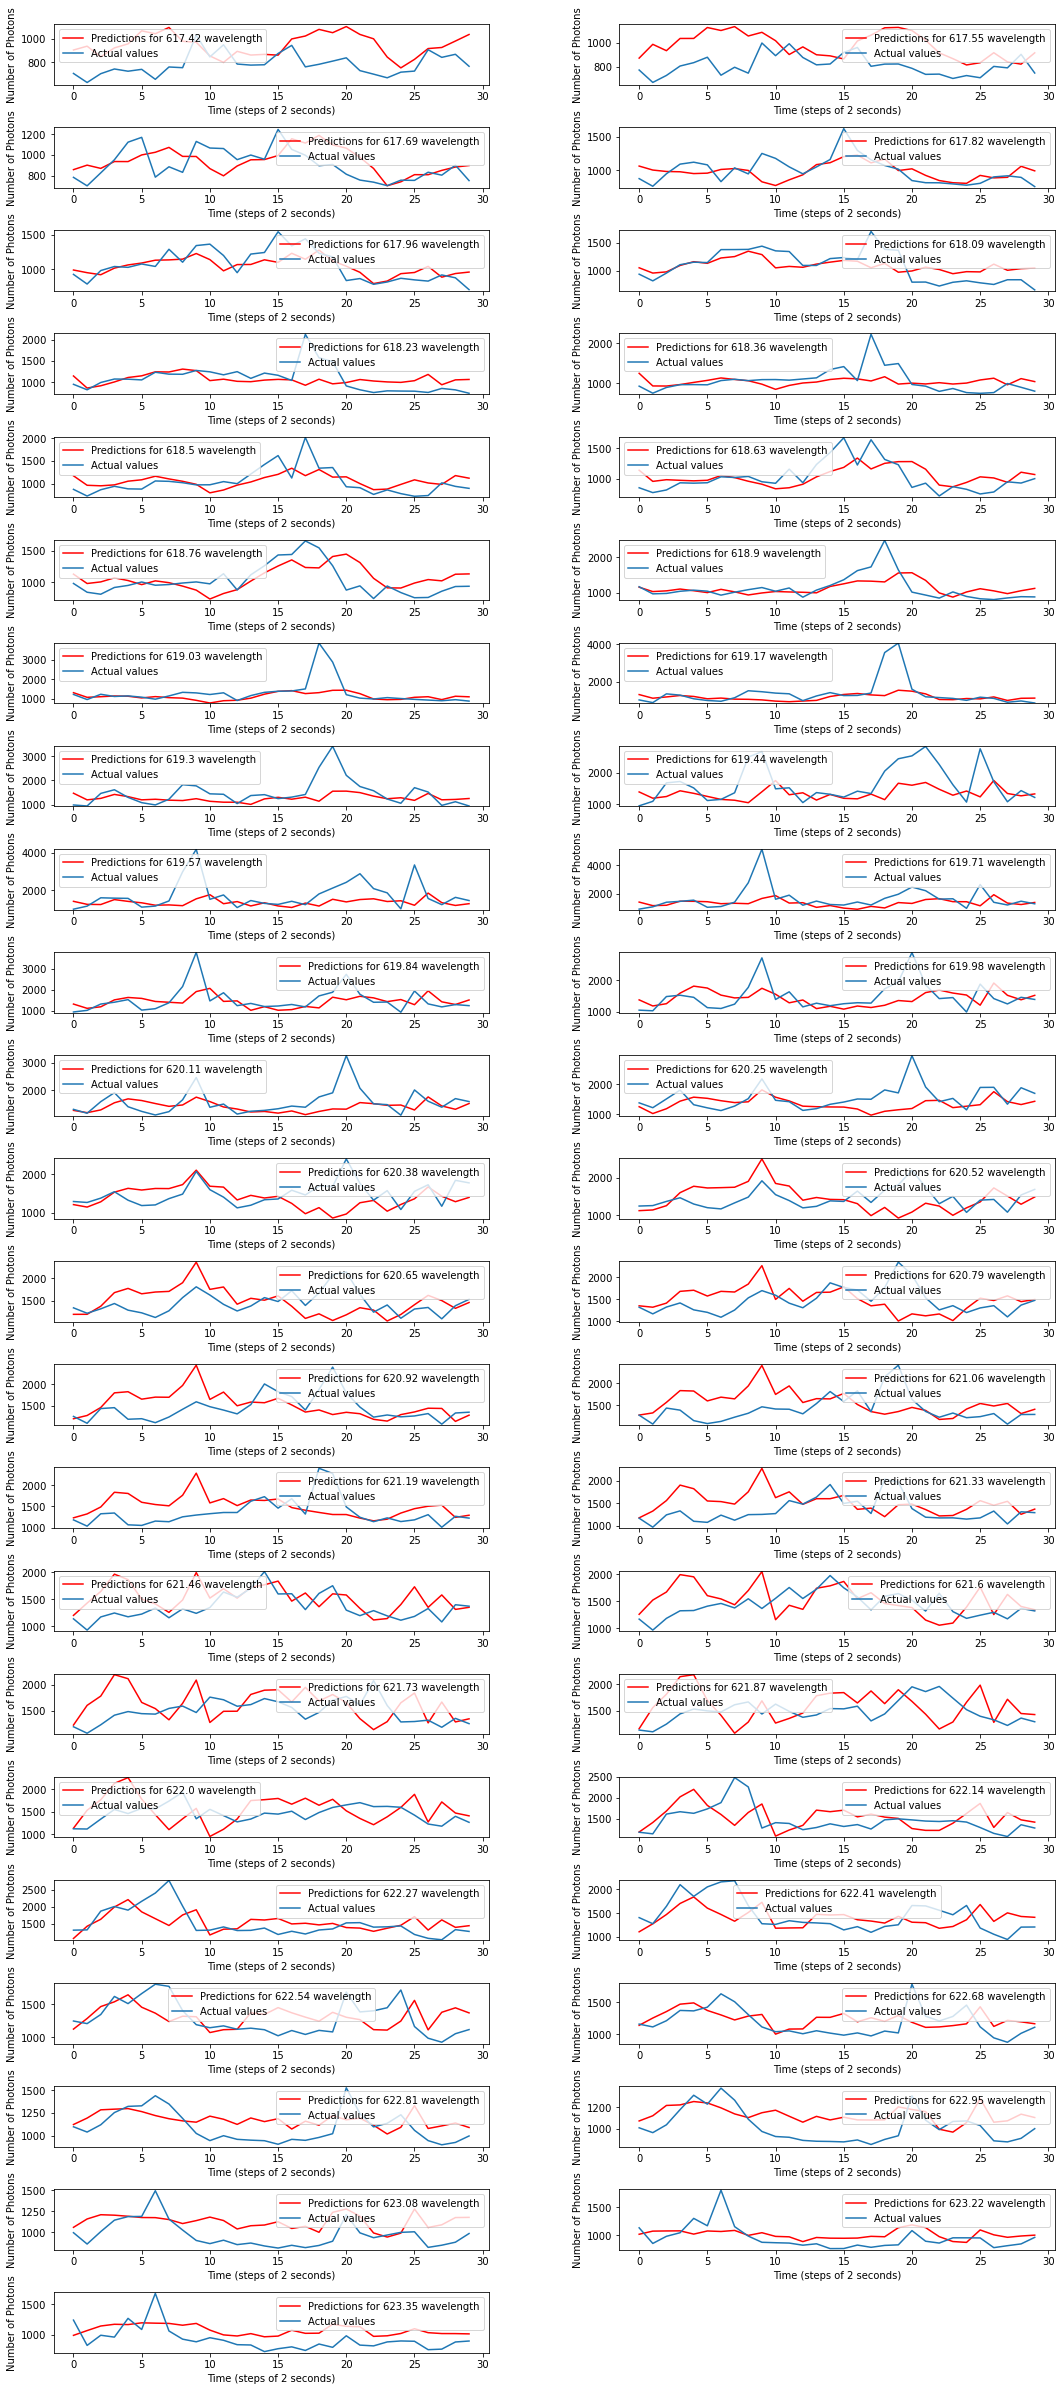

In [322]:
# Plot function and calculate rmse
# load the trained model
# model_band3=tf.keras.models.load_model('model/publish2/band/band3/')
plot_predictions_band(model_band3, X_test_band3_norm, X_train_band=X_train_band3, Y_test_band=Y_test_band3, start=0, end=20 ,ss=ss_band3, ee=ee_band3, wave_to_save=13)

<ipython-input-181-2b0c0634f735>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_band, wave_test_band, Y_test_band.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
<ipython-input-181-2b0c0634f735>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_band, wave_test_band, predictions_actual_band.T) # we can write phot_test_single instead of Y_test_single.image as well as th

Total rmse over test set using prediction model is :363.439180888947
Total rmse over test set using shifted model is :368.4039890441276


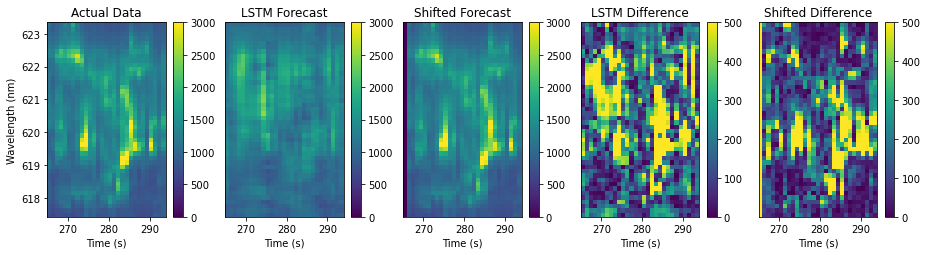

In [188]:
### plot the predictions and actual values as images 

band_image(model_band3, X_test_band3_norm, Y_test_band3, X_train_band3, df_as_np, window_size, ss=ss_band3, ee=ee_band3, thresh1=3000, thresh2=500)
# save the images
path='C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Code/QE_Forecast/Figs/'
plt.savefig(path + 'band3_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))

#### Band 4

<ipython-input-76-4ad7f150138e>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time, wave[ss_band4:ee_band4], phot.T[ss_band4:ee_band4])


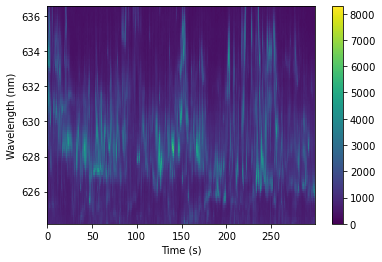

In [76]:
### Pick the fourth band and apply muti variate to them
# plot the data as an image for a range of wave
df_as_np=df.to_numpy(dtype=np.single)

wave=np.array(df.columns)
phot=df_as_np
time=np.array(df.index, dtype=int)

ss_band4=245
ee_band4=338

plt.pcolor(time, wave[ss_band4:ee_band4], phot.T[ss_band4:ee_band4])
plt.clim(0, np.amax(phot)) # plot the color bar only up to values of 3000 (max value is max(phot))
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Wavelength (nm)")
# plt.ylim(ymax = 630, ymin = 618)
plt.show()

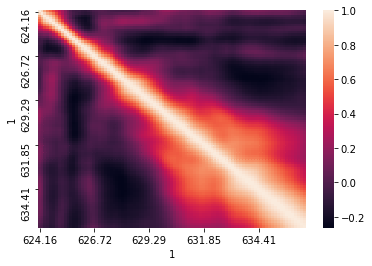

Autocorrelation for 630.37 for 30 lags


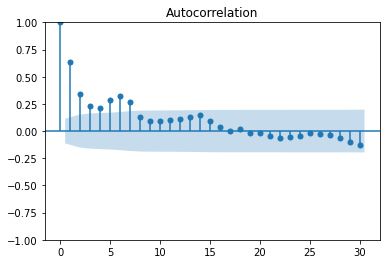

In [297]:
# plot correlation matrix as well as the autocorrelation for the middle wavelegths for band4
corr_auto(df, ss_band4, ee_band4, lags=30, fig_name='band4', ticks=19)

In [78]:
X_train_band4_norm , Y_train_band4_norm , X_val_band4_norm , Y_val_band4_norm , X_test_band4_norm , Y_test_band4_norm, Y_test_band4, X_train_band4=df_to_X_Y_band(df, window_size, ss=245, ee=338)
X_train_band4_norm.shape , Y_train_band4_norm.shape , X_val_band4_norm.shape , Y_val_band4_norm.shape , X_test_band4_norm.shape , Y_test_band4_norm.shape

((235, 5, 93), (235, 93), (31, 5, 93), (31, 93), (30, 5, 93), (30, 93))

In [79]:
cp_band4=ModelCheckpoint('model/publish2/band/band4/' , save_best_only=True) # it saves the best model based on val error
model_band4=pred_model(X_train_band4_norm, Y_train_band4_norm, batch_size=1)
model_band4.fit(X_train_band4_norm, Y_train_band4_norm, validation_data=(X_val_band4_norm, Y_val_band4_norm), batch_size=1, epochs=1300, callbacks=[cp_band4])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 128)                  113664    
                                                                 
 dense_12 (Dense)            (1, 20)                   2580      
                                                                 
 dense_13 (Dense)            (1, 93)                   1953      
                                                                 
Total params: 118,197
Trainable params: 118,197
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1300
221/235 [===========================>..] - ETA: 0s - loss: 0.9704 - root_mean_squared_error: 0.9851

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 12s 44ms/step - loss: 0.9616 - root_mean_squared_error: 0.9806 - val_loss: 0.9517 - val_root_mean_squared_error: 0.9756
Epoch 2/1300
229/235 [============================>.] - ETA: 0s - loss: 0.8132 - root_mean_squared_error: 0.9018

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 11s 46ms/step - loss: 0.8068 - root_mean_squared_error: 0.8982 - val_loss: 0.8484 - val_root_mean_squared_error: 0.9211
Epoch 3/1300
231/235 [============================>.] - ETA: 0s - loss: 0.6641 - root_mean_squared_error: 0.8149

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 10s 43ms/step - loss: 0.6584 - root_mean_squared_error: 0.8114 - val_loss: 0.7627 - val_root_mean_squared_error: 0.8734
Epoch 4/1300
229/235 [============================>.] - ETA: 0s - loss: 0.5514 - root_mean_squared_error: 0.7425

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 10s 42ms/step - loss: 0.5588 - root_mean_squared_error: 0.7476 - val_loss: 0.7060 - val_root_mean_squared_error: 0.8402
Epoch 5/1300
222/235 [===========================>..] - ETA: 0s - loss: 0.5205 - root_mean_squared_error: 0.7215

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 9s 40ms/step - loss: 0.5096 - root_mean_squared_error: 0.7138 - val_loss: 0.6771 - val_root_mean_squared_error: 0.8229
Epoch 6/1300
224/235 [===========================>..] - ETA: 0s - loss: 0.4836 - root_mean_squared_error: 0.6954

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 9s 40ms/step - loss: 0.4790 - root_mean_squared_error: 0.6921 - val_loss: 0.6551 - val_root_mean_squared_error: 0.8094
Epoch 7/1300
218/235 [==========================>...] - ETA: 0s - loss: 0.4548 - root_mean_squared_error: 0.6744

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 9s 37ms/step - loss: 0.4572 - root_mean_squared_error: 0.6761 - val_loss: 0.6403 - val_root_mean_squared_error: 0.8002
Epoch 8/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.4414 - root_mean_squared_error: 0.6644 - val_loss: 0.6406 - val_root_mean_squared_error: 0.8004
Epoch 9/1300
227/235 [===========================>..] - ETA: 0s - loss: 0.4278 - root_mean_squared_error: 0.6541

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 9s 40ms/step - loss: 0.4265 - root_mean_squared_error: 0.6531 - val_loss: 0.6185 - val_root_mean_squared_error: 0.7864
Epoch 10/1300
225/235 [===========================>..] - ETA: 0s - loss: 0.4177 - root_mean_squared_error: 0.6463

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 8s 36ms/step - loss: 0.4182 - root_mean_squared_error: 0.6467 - val_loss: 0.6019 - val_root_mean_squared_error: 0.7758
Epoch 11/1300
221/235 [===========================>..] - ETA: 0s - loss: 0.4056 - root_mean_squared_error: 0.6369

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 8s 35ms/step - loss: 0.4067 - root_mean_squared_error: 0.6377 - val_loss: 0.5946 - val_root_mean_squared_error: 0.7711
Epoch 12/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3970 - root_mean_squared_error: 0.6301 - val_loss: 0.6084 - val_root_mean_squared_error: 0.7800
Epoch 13/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3893 - root_mean_squared_error: 0.6240 - val_loss: 0.5996 - val_root_mean_squared_error: 0.7743
Epoch 14/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3804 - root_mean_squared_error: 0.6168 - val_loss: 0.6022 - val_root_mean_squared_error: 0.7760
Epoch 15/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3736 - root_mean_squared_error: 0.6112 - val_loss: 0.5951 - val_root_mean_squared_error: 0.7714
Epoch 16/1300
235/235 [==============================] - ETA: 0s - loss: 0.3666 - root_mean_squared_error: 0.6055

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 9s 38ms/step - loss: 0.3666 - root_mean_squared_error: 0.6055 - val_loss: 0.5691 - val_root_mean_squared_error: 0.7544
Epoch 17/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3598 - root_mean_squared_error: 0.5999 - val_loss: 0.5745 - val_root_mean_squared_error: 0.7579
Epoch 18/1300
223/235 [===========================>..] - ETA: 0s - loss: 0.3505 - root_mean_squared_error: 0.5920

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 8s 35ms/step - loss: 0.3540 - root_mean_squared_error: 0.5950 - val_loss: 0.5652 - val_root_mean_squared_error: 0.7518
Epoch 19/1300
219/235 [==========================>...] - ETA: 0s - loss: 0.3440 - root_mean_squared_error: 0.5865

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 9s 39ms/step - loss: 0.3482 - root_mean_squared_error: 0.5901 - val_loss: 0.5582 - val_root_mean_squared_error: 0.7471
Epoch 20/1300
220/235 [===========================>..] - ETA: 0s - loss: 0.3461 - root_mean_squared_error: 0.5883

INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


INFO:tensorflow:Assets written to: model/publish2/band/band4\assets


235/235 [==============================] - 8s 36ms/step - loss: 0.3425 - root_mean_squared_error: 0.5852 - val_loss: 0.5459 - val_root_mean_squared_error: 0.7388
Epoch 21/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3359 - root_mean_squared_error: 0.5795 - val_loss: 0.5630 - val_root_mean_squared_error: 0.7503
Epoch 22/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3320 - root_mean_squared_error: 0.5762 - val_loss: 0.5593 - val_root_mean_squared_error: 0.7479
Epoch 23/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3244 - root_mean_squared_error: 0.5696 - val_loss: 0.5674 - val_root_mean_squared_error: 0.7532
Epoch 24/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3201 - root_mean_squared_error: 0.5657 - val_loss: 0.5612 - val_root_mean_squared_error: 0.7491
Epoch 25/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.3160 - root_mean_squared_error: 0.5622 - val_loss: 0.5688 -

Epoch 67/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1913 - root_mean_squared_error: 0.4374 - val_loss: 0.6016 - val_root_mean_squared_error: 0.7756
Epoch 68/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1888 - root_mean_squared_error: 0.4346 - val_loss: 0.5995 - val_root_mean_squared_error: 0.7743
Epoch 69/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1845 - root_mean_squared_error: 0.4295 - val_loss: 0.6169 - val_root_mean_squared_error: 0.7855
Epoch 70/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1817 - root_mean_squared_error: 0.4262 - val_loss: 0.5868 - val_root_mean_squared_error: 0.7660
Epoch 71/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1798 - root_mean_squared_error: 0.4240 - val_loss: 0.6037 - val_root_mean_squared_error: 0.7770
Epoch 72/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1788 - root_mean_squared_error: 0.4228 - val_l

Epoch 114/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1138 - root_mean_squared_error: 0.3373 - val_loss: 0.6544 - val_root_mean_squared_error: 0.8089
Epoch 115/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1109 - root_mean_squared_error: 0.3330 - val_loss: 0.6747 - val_root_mean_squared_error: 0.8214
Epoch 116/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1094 - root_mean_squared_error: 0.3308 - val_loss: 0.6494 - val_root_mean_squared_error: 0.8059
Epoch 117/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1102 - root_mean_squared_error: 0.3320 - val_loss: 0.6405 - val_root_mean_squared_error: 0.8003
Epoch 118/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1073 - root_mean_squared_error: 0.3275 - val_loss: 0.6567 - val_root_mean_squared_error: 0.8103
Epoch 119/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.1066 - root_mean_squared_error: 0.3265 -

235/235 [==============================] - 1s 3ms/step - loss: 0.0698 - root_mean_squared_error: 0.2642 - val_loss: 0.6875 - val_root_mean_squared_error: 0.8292
Epoch 161/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0690 - root_mean_squared_error: 0.2627 - val_loss: 0.6617 - val_root_mean_squared_error: 0.8135
Epoch 162/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0675 - root_mean_squared_error: 0.2599 - val_loss: 0.6547 - val_root_mean_squared_error: 0.8091
Epoch 163/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0678 - root_mean_squared_error: 0.2605 - val_loss: 0.6673 - val_root_mean_squared_error: 0.8169
Epoch 164/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0672 - root_mean_squared_error: 0.2592 - val_loss: 0.6716 - val_root_mean_squared_error: 0.8195
Epoch 165/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550 - val_loss: 0.65

235/235 [==============================] - 1s 4ms/step - loss: 0.0428 - root_mean_squared_error: 0.2069 - val_loss: 0.6538 - val_root_mean_squared_error: 0.8086
Epoch 207/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0438 - root_mean_squared_error: 0.2092 - val_loss: 0.6600 - val_root_mean_squared_error: 0.8124
Epoch 208/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0422 - root_mean_squared_error: 0.2055 - val_loss: 0.6707 - val_root_mean_squared_error: 0.8189
Epoch 209/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0418 - root_mean_squared_error: 0.2046 - val_loss: 0.6613 - val_root_mean_squared_error: 0.8132
Epoch 210/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0410 - root_mean_squared_error: 0.2026 - val_loss: 0.6555 - val_root_mean_squared_error: 0.8096
Epoch 211/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0416 - root_mean_squared_error: 0.2041 - val_loss: 0.65

235/235 [==============================] - 1s 3ms/step - loss: 0.0295 - root_mean_squared_error: 0.1717 - val_loss: 0.6538 - val_root_mean_squared_error: 0.8086
Epoch 253/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0291 - root_mean_squared_error: 0.1706 - val_loss: 0.6329 - val_root_mean_squared_error: 0.7956
Epoch 254/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0293 - root_mean_squared_error: 0.1711 - val_loss: 0.6336 - val_root_mean_squared_error: 0.7960
Epoch 255/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698 - val_loss: 0.6174 - val_root_mean_squared_error: 0.7858
Epoch 256/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0290 - root_mean_squared_error: 0.1704 - val_loss: 0.6426 - val_root_mean_squared_error: 0.8016
Epoch 257/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0283 - root_mean_squared_error: 0.1683 - val_loss: 0.64

235/235 [==============================] - 1s 3ms/step - loss: 0.0223 - root_mean_squared_error: 0.1493 - val_loss: 0.6337 - val_root_mean_squared_error: 0.7961
Epoch 299/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0219 - root_mean_squared_error: 0.1480 - val_loss: 0.6242 - val_root_mean_squared_error: 0.7901
Epoch 300/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0226 - root_mean_squared_error: 0.1503 - val_loss: 0.6179 - val_root_mean_squared_error: 0.7861
Epoch 301/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0218 - root_mean_squared_error: 0.1475 - val_loss: 0.6242 - val_root_mean_squared_error: 0.7900
Epoch 302/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0219 - root_mean_squared_error: 0.1481 - val_loss: 0.6179 - val_root_mean_squared_error: 0.7861
Epoch 303/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.61

235/235 [==============================] - 1s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.6205 - val_root_mean_squared_error: 0.7877
Epoch 345/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.6168 - val_root_mean_squared_error: 0.7854
Epoch 346/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0186 - root_mean_squared_error: 0.1362 - val_loss: 0.6115 - val_root_mean_squared_error: 0.7820
Epoch 347/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.6148 - val_root_mean_squared_error: 0.7841
Epoch 348/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.6192 - val_root_mean_squared_error: 0.7869
Epoch 349/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0179 - root_mean_squared_error: 0.1336 - val_loss: 0.62

235/235 [==============================] - 1s 3ms/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.6107 - val_root_mean_squared_error: 0.7815
Epoch 391/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0156 - root_mean_squared_error: 0.1248 - val_loss: 0.6221 - val_root_mean_squared_error: 0.7887
Epoch 392/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0151 - root_mean_squared_error: 0.1230 - val_loss: 0.6178 - val_root_mean_squared_error: 0.7860
Epoch 393/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0154 - root_mean_squared_error: 0.1243 - val_loss: 0.6163 - val_root_mean_squared_error: 0.7851
Epoch 394/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233 - val_loss: 0.6191 - val_root_mean_squared_error: 0.7868
Epoch 395/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0152 - root_mean_squared_error: 0.1235 - val_loss: 0.61

235/235 [==============================] - 1s 3ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.6100 - val_root_mean_squared_error: 0.7810
Epoch 437/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0133 - root_mean_squared_error: 0.1153 - val_loss: 0.6051 - val_root_mean_squared_error: 0.7779
Epoch 438/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.6177 - val_root_mean_squared_error: 0.7859
Epoch 439/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.6180 - val_root_mean_squared_error: 0.7861
Epoch 440/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163 - val_loss: 0.6130 - val_root_mean_squared_error: 0.7829
Epoch 441/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.60

235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101 - val_loss: 0.6189 - val_root_mean_squared_error: 0.7867
Epoch 483/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088 - val_loss: 0.6108 - val_root_mean_squared_error: 0.7815
Epoch 484/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.6129 - val_root_mean_squared_error: 0.7829
Epoch 485/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.6160 - val_root_mean_squared_error: 0.7849
Epoch 486/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.6126 - val_root_mean_squared_error: 0.7827
Epoch 487/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.61

235/235 [==============================] - 1s 3ms/step - loss: 0.0108 - root_mean_squared_error: 0.1040 - val_loss: 0.6155 - val_root_mean_squared_error: 0.7845
Epoch 529/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.6135 - val_root_mean_squared_error: 0.7832
Epoch 530/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0108 - root_mean_squared_error: 0.1042 - val_loss: 0.6250 - val_root_mean_squared_error: 0.7905
Epoch 531/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.6139 - val_root_mean_squared_error: 0.7835
Epoch 532/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.6139 - val_root_mean_squared_error: 0.7835
Epoch 533/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.61

235/235 [==============================] - 1s 3ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.6116 - val_root_mean_squared_error: 0.7820
Epoch 575/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.6173 - val_root_mean_squared_error: 0.7857
Epoch 576/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0100 - root_mean_squared_error: 0.0999 - val_loss: 0.6095 - val_root_mean_squared_error: 0.7807
Epoch 577/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.6116 - val_root_mean_squared_error: 0.7820
Epoch 578/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.6081 - val_root_mean_squared_error: 0.7798
Epoch 579/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.61

235/235 [==============================] - 1s 3ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.6094 - val_root_mean_squared_error: 0.7807
Epoch 621/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.6023 - val_root_mean_squared_error: 0.7761
Epoch 622/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.6013 - val_root_mean_squared_error: 0.7755
Epoch 623/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.6016 - val_root_mean_squared_error: 0.7756
Epoch 624/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0095 - root_mean_squared_error: 0.0972 - val_loss: 0.6062 - val_root_mean_squared_error: 0.7786
Epoch 625/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.60

235/235 [==============================] - 1s 3ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943 - val_loss: 0.6080 - val_root_mean_squared_error: 0.7797
Epoch 667/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.6035 - val_root_mean_squared_error: 0.7768
Epoch 668/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.6032 - val_root_mean_squared_error: 0.7766
Epoch 669/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.6007 - val_root_mean_squared_error: 0.7751
Epoch 670/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.6052 - val_root_mean_squared_error: 0.7780
Epoch 671/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.59

235/235 [==============================] - 1s 3ms/step - loss: 0.0086 - root_mean_squared_error: 0.0929 - val_loss: 0.5848 - val_root_mean_squared_error: 0.7647
Epoch 713/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.5979 - val_root_mean_squared_error: 0.7732
Epoch 714/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0085 - root_mean_squared_error: 0.0923 - val_loss: 0.5914 - val_root_mean_squared_error: 0.7690
Epoch 715/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.5983 - val_root_mean_squared_error: 0.7735
Epoch 716/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.5905 - val_root_mean_squared_error: 0.7684
Epoch 717/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.58

235/235 [==============================] - 1s 3ms/step - loss: 0.0083 - root_mean_squared_error: 0.0908 - val_loss: 0.5858 - val_root_mean_squared_error: 0.7654
Epoch 759/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.5935 - val_root_mean_squared_error: 0.7704
Epoch 760/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.5952 - val_root_mean_squared_error: 0.7715
Epoch 761/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.5910 - val_root_mean_squared_error: 0.7688
Epoch 762/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.5900 - val_root_mean_squared_error: 0.7681
Epoch 763/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.59

235/235 [==============================] - 1s 3ms/step - loss: 0.0081 - root_mean_squared_error: 0.0903 - val_loss: 0.5943 - val_root_mean_squared_error: 0.7709
Epoch 805/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.5873 - val_root_mean_squared_error: 0.7664
Epoch 806/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.5877 - val_root_mean_squared_error: 0.7666
Epoch 807/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.5929 - val_root_mean_squared_error: 0.7700
Epoch 808/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.5866 - val_root_mean_squared_error: 0.7659
Epoch 809/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.58

235/235 [==============================] - 1s 3ms/step - loss: 0.0080 - root_mean_squared_error: 0.0897 - val_loss: 0.5806 - val_root_mean_squared_error: 0.7620
Epoch 851/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.5816 - val_root_mean_squared_error: 0.7626
Epoch 852/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.5871 - val_root_mean_squared_error: 0.7662
Epoch 853/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0079 - root_mean_squared_error: 0.0889 - val_loss: 0.5830 - val_root_mean_squared_error: 0.7635
Epoch 854/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.5829 - val_root_mean_squared_error: 0.7635
Epoch 855/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.58

235/235 [==============================] - 1s 3ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.5754 - val_root_mean_squared_error: 0.7586
Epoch 897/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.5804 - val_root_mean_squared_error: 0.7619
Epoch 898/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.5770 - val_root_mean_squared_error: 0.7596
Epoch 899/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.5790 - val_root_mean_squared_error: 0.7609
Epoch 900/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.5814 - val_root_mean_squared_error: 0.7625
Epoch 901/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.57

235/235 [==============================] - 1s 3ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.5781 - val_root_mean_squared_error: 0.7604
Epoch 943/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.5781 - val_root_mean_squared_error: 0.7603
Epoch 944/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.5782 - val_root_mean_squared_error: 0.7604
Epoch 945/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.5721 - val_root_mean_squared_error: 0.7564
Epoch 946/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0076 - root_mean_squared_error: 0.0875 - val_loss: 0.5799 - val_root_mean_squared_error: 0.7615
Epoch 947/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.57

235/235 [==============================] - 1s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0869 - val_loss: 0.5721 - val_root_mean_squared_error: 0.7564
Epoch 989/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.5681 - val_root_mean_squared_error: 0.7537
Epoch 990/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.5729 - val_root_mean_squared_error: 0.7569
Epoch 991/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.5721 - val_root_mean_squared_error: 0.7564
Epoch 992/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.5729 - val_root_mean_squared_error: 0.7569
Epoch 993/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.57

235/235 [==============================] - 1s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.5714 - val_root_mean_squared_error: 0.7559
Epoch 1035/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.5672 - val_root_mean_squared_error: 0.7531
Epoch 1036/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.5708 - val_root_mean_squared_error: 0.7555
Epoch 1037/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.5705 - val_root_mean_squared_error: 0.7553
Epoch 1038/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.5749 - val_root_mean_squared_error: 0.7582
Epoch 1039/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.5690 - val_root_mean_squared_error: 0.7544
Epoch 1081/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.5717 - val_root_mean_squared_error: 0.7561
Epoch 1082/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.5733 - val_root_mean_squared_error: 0.7572
Epoch 1083/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.5703 - val_root_mean_squared_error: 0.7552
Epoch 1084/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.5715 - val_root_mean_squared_error: 0.7560
Epoch 1085/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.5737 - val_root_mean_squared_error: 0.7574
Epoch 1127/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.5724 - val_root_mean_squared_error: 0.7566
Epoch 1128/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.5660 - val_root_mean_squared_error: 0.7523
Epoch 1129/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.5676 - val_root_mean_squared_error: 0.7534
Epoch 1130/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.5669 - val_root_mean_squared_error: 0.7529
Epoch 1131/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.5700 - val_root_mean_squared_error: 0.7550
Epoch 1173/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.5676 - val_root_mean_squared_error: 0.7534
Epoch 1174/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.5661 - val_root_mean_squared_error: 0.7524
Epoch 1175/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.5664 - val_root_mean_squared_error: 0.7526
Epoch 1176/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.5631 - val_root_mean_squared_error: 0.7504
Epoch 1177/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss:

235/235 [==============================] - 1s 4ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.5695 - val_root_mean_squared_error: 0.7546
Epoch 1219/1300
235/235 [==============================] - 1s 5ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.5676 - val_root_mean_squared_error: 0.7534
Epoch 1220/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.5699 - val_root_mean_squared_error: 0.7549
Epoch 1221/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.5676 - val_root_mean_squared_error: 0.7534
Epoch 1222/1300
235/235 [==============================] - 1s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.5676 - val_root_mean_squared_error: 0.7534
Epoch 1223/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss:

235/235 [==============================] - 1s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.5698 - val_root_mean_squared_error: 0.7548
Epoch 1265/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0069 - root_mean_squared_error: 0.0834 - val_loss: 0.5695 - val_root_mean_squared_error: 0.7546
Epoch 1266/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.5672 - val_root_mean_squared_error: 0.7531
Epoch 1267/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.5651 - val_root_mean_squared_error: 0.7517
Epoch 1268/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.5652 - val_root_mean_squared_error: 0.7518
Epoch 1269/1300
235/235 [==============================] - 1s 3ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss:

305.5458160263168

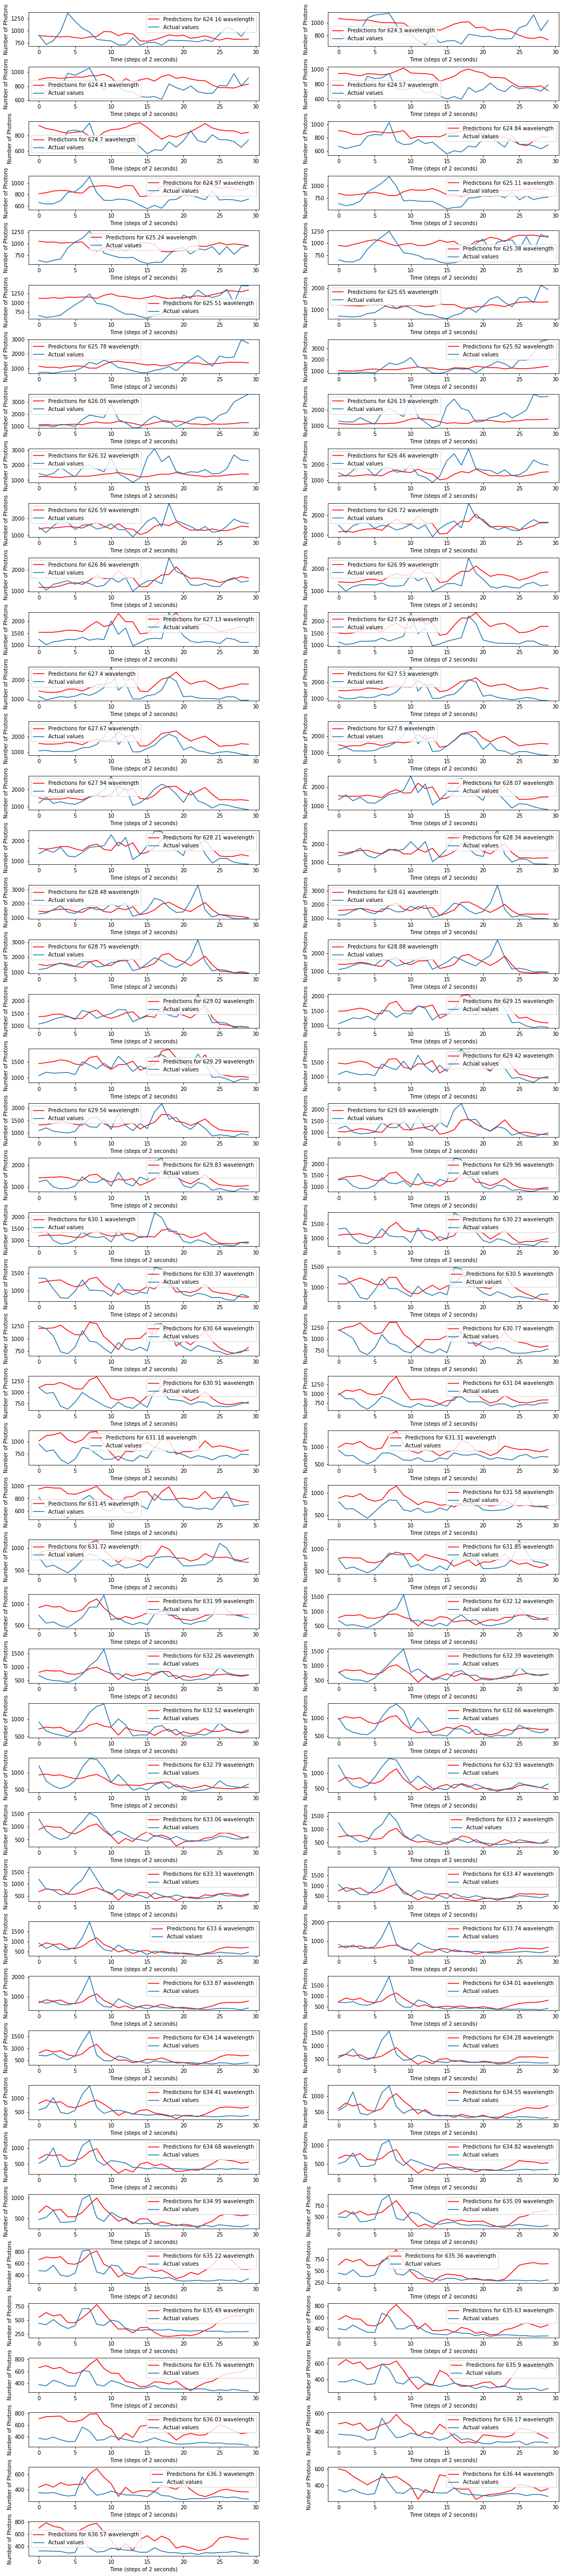

In [114]:
# Plot function and calculate rmse
# load the trained model
model_band4=tf.keras.models.load_model('model/publish2/band/band4/')
plot_predictions_band(model_band4, X_test_band4_norm, X_train_band=X_train_band4, Y_test_band=Y_test_band4, start=0, end=20 ,ss=ss_band4, ee=ee_band4, wave_to_save=13)

<ipython-input-181-2b0c0634f735>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_band, wave_test_band, Y_test_band.T) # we can write phot_test_single instead of Y_test_single.image as well as they are the same
<ipython-input-181-2b0c0634f735>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(time_test_band, wave_test_band, predictions_actual_band.T) # we can write phot_test_single instead of Y_test_single.image as well as th

Total rmse over test set using prediction model is :305.51959721961896
Total rmse over test set using shifted model is :296.0520827396577


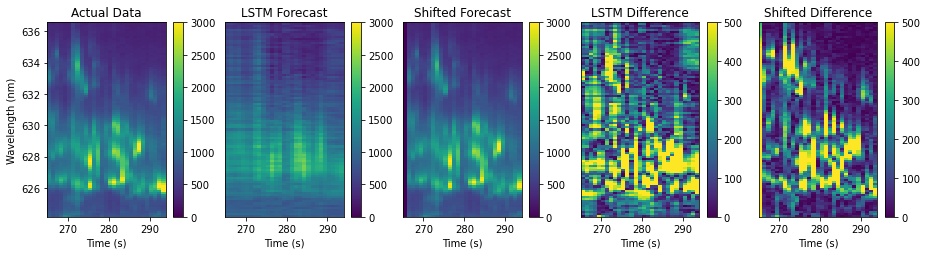

In [189]:
### plot the predictions and actual values as images 

band_image(model_band4, X_test_band4_norm, Y_test_band4, X_train_band4, df_as_np, window_size, ss=ss_band4, ee=ee_band4, thresh1=3000, thresh2=500)
# save the images
path='C:/Users/s31x694/OneDrive - Montana State University/FRamezani/MSU/GRA/Emission-Prediction-Project/Code/QE_Forecast/Figs/'
plt.savefig(path + 'band4_images.png',dpi=300, bbox_inches='tight', facecolor=(1, 1, 1))